# Ground-Truth Generation basato su VIN

## Obiettivo 4.A
Generare un **ground-truth** per valutare diverse soluzioni di integrazione e addestrare modelli di ML.

### Strategia:
1. **Validazione VIN**: Identificare VIN validi (17 caratteri, formato corretto)
2. **Matching VIN**: Trovare VIN presenti in entrambi i dataset
3. **Validazione consistenza**: Verificare coerenza di altri attributi (year, manufacturer, model)
4. **Pulizia anomalie**: Rimuovere match con discrepanze significative
5. **Analisi rappresentatività**: Verificare copertura di prezzo, anno, produttori
6. **Creazione ground-truth**: Salvare dataset di coppie validate

### Nota sul rumore nei dati:
I dati possono contenere:
- VIN duplicati (stesso veicolo venduto più volte)
- VIN malformati o incompleti
- Errori di battitura negli attributi
- Prezzi anomali
- Informazioni contrastanti tra i dataset

## 1. Import Librerie e Caricamento Dati

In [3]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import re
from datetime import datetime
import json

# Configurazione visualizzazioni
plt.style.use('seaborn-v0_8-darkgrid')
sns.set_palette("husl")
pd.set_option('display.max_columns', None)

print("Librerie importate con successo!")

Librerie importate con successo!


In [4]:
# Caricamento dataset ALLINEATI (già puliti e normalizzati)
print("Caricamento dataset allineati...")
print("📁 Sorgente: schema/craigslist_aligned.csv e schema/used_cars_aligned.csv")
print("   (Dataset già normalizzati dal processo di schema mediation)\n")

df_craigslist = pd.read_csv('schema/craigslist_aligned.csv')
df_used_cars = pd.read_csv('schema/used_cars_aligned.csv')

print(f"Dataset Craigslist Allineato: {len(df_craigslist):,} righe × {len(df_craigslist.columns)} colonne")
print(f"Dataset Used Cars Allineato: {len(df_used_cars):,} righe × {len(df_used_cars.columns)} colonne")

# Verifica presenza colonna vin (nei dataset allineati la colonna è 'vin' in minuscolo)
print(f"\nColonna 'vin' in Craigslist: {'vin' in df_craigslist.columns}")
print(f"Colonna 'vin' in Used Cars: {'vin' in df_used_cars.columns}")

# Mostra prime colonne per verifica schema
print(f"\nPrime colonne Craigslist: {list(df_craigslist.columns[:10])}")
print(f"Prime colonne Used Cars: {list(df_used_cars.columns[:10])}")

Caricamento dataset allineati...
📁 Sorgente: schema/craigslist_aligned.csv e schema/used_cars_aligned.csv
   (Dataset già normalizzati dal processo di schema mediation)

Dataset Craigslist Allineato: 426,880 righe × 20 colonne
Dataset Used Cars Allineato: 3,000,040 righe × 20 colonne

Colonna 'vin' in Craigslist: True
Colonna 'vin' in Used Cars: True

Prime colonne Craigslist: ['body_type', 'cylinders', 'description', 'drive_type', 'exterior_color', 'fuel_type', 'image_url', 'latitude', 'listing_date', 'location']
Prime colonne Used Cars: ['body_type', 'cylinders', 'description', 'drive_type', 'exterior_color', 'fuel_type', 'image_url', 'latitude', 'listing_date', 'location']


## 2. Analisi e Validazione VIN

Un VIN valido deve:
- Essere lungo esattamente **17 caratteri**
- Contenere solo caratteri alfanumerici (esclusi I, O, Q per evitare confusione)
- Avere una struttura specifica: WMI (3) + VDS (6) + VIS (8)

In [5]:
def validate_vin(vin):
    """
    Valida un VIN secondo gli standard internazionali.
    
    Args:
        vin: Stringa VIN da validare
        
    Returns:
        bool: True se il VIN è valido, False altrimenti
    """
    if pd.isna(vin):
        return False
    
    vin_str = str(vin).strip().upper()
    
    # Verifica lunghezza (deve essere 17 caratteri)
    if len(vin_str) != 17:
        return False
    
    # Verifica che contenga solo caratteri alfanumerici (no I, O, Q)
    if not re.match(r'^[A-HJ-NPR-Z0-9]{17}$', vin_str):
        return False
    
    return True

def clean_vin(vin):
    """
    Pulisce e normalizza un VIN.
    
    Args:
        vin: Stringa VIN da pulire
        
    Returns:
        str: VIN pulito e normalizzato, o None se non valido
    """
    if pd.isna(vin):
        return None
    
    # Converti in maiuscolo e rimuovi spazi
    vin_clean = str(vin).strip().upper().replace(' ', '').replace('-', '')
    
    # Valida
    if validate_vin(vin_clean):
        return vin_clean
    else:
        return None

print("Funzioni di validazione VIN definite.")
print("\nTest validazione:")
test_vins = ['1HGBH41JXMN109186', '1234567890', 'INVALID', None, '1HGBH41JX MN109186']
for test_vin in test_vins:
    cleaned = clean_vin(test_vin)
    print(f"  '{test_vin}' -> '{cleaned}' (valido: {validate_vin(cleaned) if cleaned else False})")

Funzioni di validazione VIN definite.

Test validazione:
  '1HGBH41JXMN109186' -> '1HGBH41JXMN109186' (valido: True)
  '1234567890' -> 'None' (valido: False)
  'INVALID' -> 'None' (valido: False)
  'None' -> 'None' (valido: False)
  '1HGBH41JX MN109186' -> '1HGBH41JXMN109186' (valido: True)


In [6]:
# Analisi VIN nei dataset ALLINEATI
print("ANALISI VIN NEI DATASET ALLINEATI")
print("=" * 80)
print("ℹ️  I dataset allineati hanno già VIN normalizzati (uppercase, stripped)")
print()

# Craigslist Allineato
print("\n1. DATASET CRAIGSLIST ALLINEATO:")
print("-" * 80)
total_cr = len(df_craigslist)
vin_present_cr = df_craigslist['vin'].notna().sum()
print(f"  Totale righe: {total_cr:,}")
print(f"  VIN presenti: {vin_present_cr:,} ({vin_present_cr/total_cr*100:.2f}%)")
print(f"  VIN mancanti: {total_cr - vin_present_cr:,} ({(total_cr-vin_present_cr)/total_cr*100:.2f}%)")

# Applica validazione (i VIN sono già puliti ma verifichiamo)
df_craigslist['vin_clean'] = df_craigslist['vin'].apply(clean_vin)
vin_valid_cr = df_craigslist['vin_clean'].notna().sum()
vin_unique_cr = df_craigslist['vin_clean'].nunique()

print(f"  VIN validi (17 char): {vin_valid_cr:,} ({vin_valid_cr/total_cr*100:.2f}%)")
print(f"  VIN unici validi: {vin_unique_cr:,}")
print(f"  VIN duplicati: {vin_valid_cr - vin_unique_cr:,}")

# Used Cars Allineato
print("\n2. DATASET USED CARS ALLINEATO:")
print("-" * 80)
total_uc = len(df_used_cars)
vin_present_uc = df_used_cars['vin'].notna().sum()
print(f"  Totale righe: {total_uc:,}")
print(f"  VIN presenti: {vin_present_uc:,} ({vin_present_uc/total_uc*100:.2f}%)")
print(f"  VIN mancanti: {total_uc - vin_present_uc:,} ({(total_uc-vin_present_uc)/total_uc*100:.2f}%)")

# Applica validazione
df_used_cars['vin_clean'] = df_used_cars['vin'].apply(clean_vin)
vin_valid_uc = df_used_cars['vin_clean'].notna().sum()
vin_unique_uc = df_used_cars['vin_clean'].nunique()

print(f"  VIN validi (17 char): {vin_valid_uc:,} ({vin_valid_uc/total_uc*100:.2f}%)")
print(f"  VIN unici validi: {vin_unique_uc:,}")
print(f"  VIN duplicati: {vin_valid_uc - vin_unique_uc:,}")

ANALISI VIN NEI DATASET ALLINEATI
ℹ️  I dataset allineati hanno già VIN normalizzati (uppercase, stripped)


1. DATASET CRAIGSLIST ALLINEATO:
--------------------------------------------------------------------------------
  Totale righe: 426,880
  VIN presenti: 265,838 (62.27%)
  VIN mancanti: 161,042 (37.73%)
  VIN validi (17 char): 264,239 (61.90%)
  VIN unici validi: 117,127
  VIN duplicati: 147,112

2. DATASET USED CARS ALLINEATO:
--------------------------------------------------------------------------------
  Totale righe: 3,000,040
  VIN presenti: 3,000,040 (100.00%)
  VIN mancanti: 0 (0.00%)
  VIN validi (17 char): 2,996,955 (99.90%)
  VIN unici validi: 2,996,915
  VIN duplicati: 40


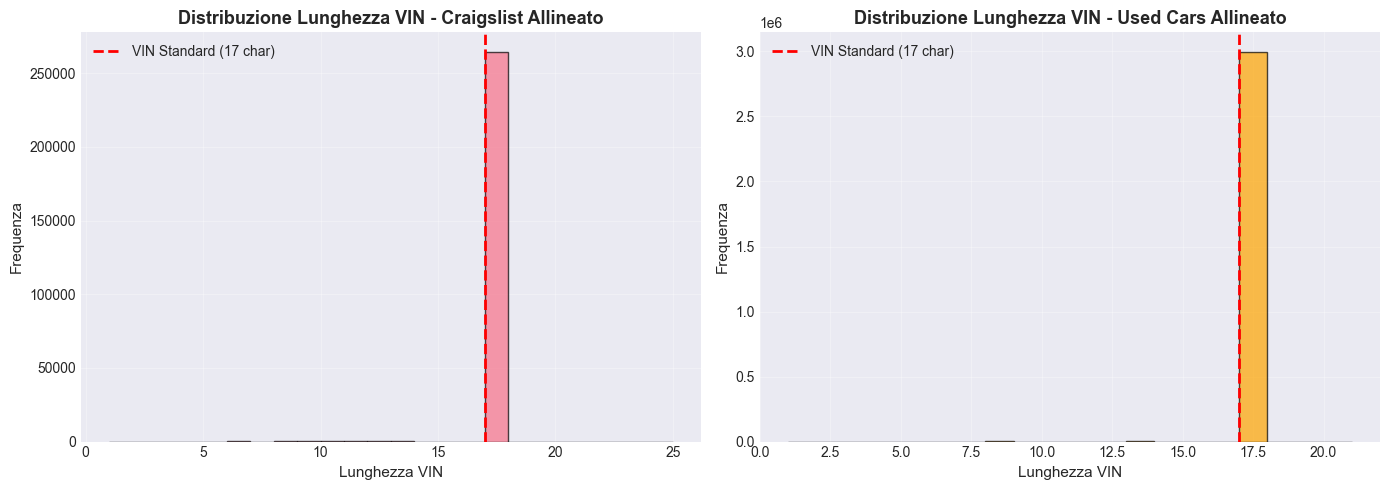


Statistiche lunghezza VIN:
  Craigslist - VIN a 17 caratteri: 264,520 / 265,838 (99.5%)
  Used Cars - VIN a 17 caratteri: 2,996,988 / 3,000,040 (99.9%)


In [7]:
# Visualizzazione distribuzione lunghezza VIN
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(14, 5))

# Craigslist Allineato
vin_lengths_cr = df_craigslist['vin'].dropna().astype(str).str.len()
ax1.hist(vin_lengths_cr, bins=range(1, max(vin_lengths_cr)+2), edgecolor='black', alpha=0.7)
ax1.axvline(x=17, color='red', linestyle='--', linewidth=2, label='VIN Standard (17 char)')
ax1.set_xlabel('Lunghezza VIN', fontsize=11)
ax1.set_ylabel('Frequenza', fontsize=11)
ax1.set_title('Distribuzione Lunghezza VIN - Craigslist Allineato', fontsize=13, fontweight='bold')
ax1.legend()
ax1.grid(alpha=0.3)

# Used Cars
vin_lengths_uc = df_used_cars['vin'].dropna().astype(str).str.len()
ax2.hist(vin_lengths_uc, bins=range(1, max(vin_lengths_uc)+2), edgecolor='black', alpha=0.7, color='orange')
ax2.axvline(x=17, color='red', linestyle='--', linewidth=2, label='VIN Standard (17 char)')
ax2.set_xlabel('Lunghezza VIN', fontsize=11)
ax2.set_ylabel('Frequenza', fontsize=11)
ax2.set_title('Distribuzione Lunghezza VIN - Used Cars Allineato', fontsize=13, fontweight='bold')
ax2.legend()
ax2.grid(alpha=0.3)

plt.tight_layout()
plt.show()

print("\nStatistiche lunghezza VIN:")
print(f"  Craigslist - VIN a 17 caratteri: {(vin_lengths_cr == 17).sum():,} / {len(vin_lengths_cr):,} ({(vin_lengths_cr == 17).sum()/len(vin_lengths_cr)*100:.1f}%)")
print(f"  Used Cars - VIN a 17 caratteri: {(vin_lengths_uc == 17).sum():,} / {len(vin_lengths_uc):,} ({(vin_lengths_uc == 17).sum()/len(vin_lengths_uc)*100:.1f}%)")

## 3. Pre-Processing e Deduplicazione VIN

**STEP 1**: Deduplicare i dataset su VIN per evitare prodotti cartesiani nei match.

Problema: Lo stesso veicolo può apparire più volte (stesso VIN) specialmente in Craigslist (annunci ripubblicati).
Un merge naive genererebbe coppie duplicate (1 auto a SX × 3 annunci a DX = 3 coppie identiche).

Soluzione: Manteniamo solo la **prima occorrenza** di ogni VIN univoco.

In [8]:
# DEDUPLICAZIONE: Mantieni solo prima occorrenza per VIN
print("DEDUPLICAZIONE VIN")
print("=" * 80)

# Craigslist - prima della deduplicazione
print(f"\nCraigslist PRIMA della deduplicazione:")
print(f"  Totale record: {len(df_craigslist):,}")
vin_counts_cr = df_craigslist['vin_clean'].value_counts()
duplicates_cr = (vin_counts_cr > 1).sum()
print(f"  Record con VIN valido: {df_craigslist['vin_clean'].notna().sum():,}")
print(f"  VIN duplicati: {duplicates_cr:,}")
if duplicates_cr > 0:
    print(f"  Top 5 VIN più duplicati:")
    for vin, count in vin_counts_cr.head().items():
        print(f"    {vin}: {count} occorrenze")

# Deduplicazione Craigslist
df_craigslist_dedup = df_craigslist[df_craigslist['vin_clean'].notna()].drop_duplicates(subset=['vin_clean'], keep='first')
print(f"\nCraigslist DOPO la deduplicazione:")
print(f"  Record unici: {len(df_craigslist_dedup):,}")
print(f"  Record rimossi: {df_craigslist['vin_clean'].notna().sum() - len(df_craigslist_dedup):,}")

# Used Cars - prima della deduplicazione
print(f"\nUsed Cars PRIMA della deduplicazione:")
print(f"  Totale record: {len(df_used_cars):,}")
vin_counts_uc = df_used_cars['vin_clean'].value_counts()
duplicates_uc = (vin_counts_uc > 1).sum()
print(f"  Record con VIN valido: {df_used_cars['vin_clean'].notna().sum():,}")
print(f"  VIN duplicati: {duplicates_uc:,}")
if duplicates_uc > 0:
    print(f"  Top 5 VIN più duplicati:")
    for vin, count in vin_counts_uc.head().items():
        print(f"    {vin}: {count} occorrenze")

# Deduplicazione Used Cars
df_used_cars_dedup = df_used_cars[df_used_cars['vin_clean'].notna()].drop_duplicates(subset=['vin_clean'], keep='first')
print(f"\nUsed Cars DOPO la deduplicazione:")
print(f"  Record unici: {len(df_used_cars_dedup):,}")
print(f"  Record rimossi: {df_used_cars['vin_clean'].notna().sum() - len(df_used_cars_dedup):,}")

# Estrai VIN validi DEDUPLICATI
vins_craigslist = set(df_craigslist_dedup['vin_clean'].dropna())
vins_used_cars = set(df_used_cars_dedup['vin_clean'].dropna())

print("\n" + "=" * 80)
print("IDENTIFICAZIONE VIN COMUNI (DOPO DEDUPLICAZIONE)")
print("=" * 80)
print(f"\nVIN validi unici in Craigslist: {len(vins_craigslist):,}")
print(f"VIN validi unici in Used Cars: {len(vins_used_cars):,}")

# Trova intersezione
common_vins = vins_craigslist.intersection(vins_used_cars)
print(f"\n🎯 VIN comuni tra i due dataset: {len(common_vins):,}")

if len(common_vins) > 0:
    overlap_cr = len(common_vins) / len(vins_craigslist) * 100
    overlap_uc = len(common_vins) / len(vins_used_cars) * 100
    print(f"   - Rappresentano il {overlap_cr:.2f}% dei VIN Craigslist")
    print(f"   - Rappresentano il {overlap_uc:.2f}% dei VIN Used Cars")
else:
    print("\n⚠ ATTENZIONE: Nessun VIN comune trovato!")
    print("   Possibili cause:")
    print("   - Dataset rappresentano mercati/periodi diversi")
    print("   - VIN formattati diversamente")
    print("   - Problemi di qualità dei dati")

DEDUPLICAZIONE VIN

Craigslist PRIMA della deduplicazione:
  Totale record: 426,880
  Record con VIN valido: 264,239
  VIN duplicati: 40,089
  Top 5 VIN più duplicati:
    1FMJU1JT1HEA52352: 261 occorrenze
    3C6JR6DT3KG560649: 235 occorrenze
    1FTER1EH1LLA36301: 231 occorrenze
    5TFTX4CN3EX042751: 227 occorrenze
    1GCHTCE37G1186784: 214 occorrenze

Craigslist DOPO la deduplicazione:
  Record unici: 117,127
  Record rimossi: 147,112

Used Cars PRIMA della deduplicazione:
  Totale record: 3,000,040
  Record con VIN valido: 2,996,955
  VIN duplicati: 40
  Top 5 VIN più duplicati:
    3FA6P0H79GR344482: 2 occorrenze
    3TMCZ5AN4KM203273: 2 occorrenze
    1FTEW1EP0HKC03244: 2 occorrenze
    3FADP4EJ0KM129514: 2 occorrenze
    1N6AD0EV6KN713209: 2 occorrenze

Used Cars DOPO la deduplicazione:
  Record unici: 2,996,915
  Record rimossi: 40

IDENTIFICAZIONE VIN COMUNI (DOPO DEDUPLICAZIONE)

VIN validi unici in Craigslist: 117,127
VIN validi unici in Used Cars: 2,996,915

🎯 VIN comuni 

In [9]:
# Se abbiamo VIN comuni, procediamo con la creazione dei match
if len(common_vins) > 0:
    # Filtra record con VIN comuni DAI DATASET DEDUPLICATI
    df_cr_matched = df_craigslist_dedup[df_craigslist_dedup['vin_clean'].isin(common_vins)].copy()
    df_uc_matched = df_used_cars_dedup[df_used_cars_dedup['vin_clean'].isin(common_vins)].copy()
    
    print(f"\nRECORD CON VIN COMUNI:")
    print(f"  Craigslist: {len(df_cr_matched):,} record")
    print(f"  Used Cars: {len(df_uc_matched):,} record")
    
    # Conta duplicati VIN
    dup_cr = df_cr_matched['vin_clean'].value_counts()
    dup_uc = df_uc_matched['vin_clean'].value_counts()
    
    print(f"\n  VIN duplicati in Craigslist: {(dup_cr > 1).sum():,}")
    print(f"  VIN duplicati in Used Cars: {(dup_uc > 1).sum():,}")
    
    if (dup_cr > 1).sum() > 0:
        print(f"\n  Top 5 VIN più frequenti in Craigslist:")
        for vin, count in dup_cr.head().items():
            print(f"    {vin}: {count} occorrenze")
    
    if (dup_uc > 1).sum() > 0:
        print(f"\n  Top 5 VIN più frequenti in Used Cars:")
        for vin, count in dup_uc.head().items():
            print(f"    {vin}: {count} occorrenze")
else:
    print("\n❌ Impossibile procedere senza VIN comuni.")
    print("   Considerare strategie alternative per il ground-truth:")
    print("   - Matching probabilistico su (year, make, model, price)")
    print("   - Crowdsourcing o validazione manuale")
    print("   - Utilizzare regole di business per identificare match probabili")


RECORD CON VIN COMUNI:
  Craigslist: 3,947 record
  Used Cars: 3,947 record

  VIN duplicati in Craigslist: 0
  VIN duplicati in Used Cars: 0


## 4. Positive Matches con Anti-Noise Filter

Creiamo **Positive Matches (label=1)** tramite join su VIN con validazione consistenza.

**Anti-Noise Filter**: Se VIN coincide MA manufacturer diverso → SCARTA (VIN errato o riciclato)

In [10]:
if len(common_vins) > 0:
    # Crea mapping degli attributi per confronto (SCHEMA ALLINEATO - colonne comuni)
    # Nei dataset allineati le colonne hanno NOMI IDENTICI
    attr_mapping = {
        'year': ('year', 'year'),
        'manufacturer': ('manufacturer', 'manufacturer'),  # Stesso nome nello schema allineato
        'model': ('model', 'model'),                        # Stesso nome nello schema allineato
        'price': ('price', 'price'),
        'mileage': ('mileage', 'mileage'),                  # Stesso nome nello schema allineato
    }
    
    # Funzione per validare un match
    def validate_match(row_cr, row_uc):
        """
        Valida la consistenza tra due record con stesso VIN.
        Usa lo SCHEMA ALLINEATO dove le colonne hanno nomi identici.
        
        Returns:
            dict: Dizionario con risultati validazione
        """
        validation = {
            'vin': row_cr['vin_clean'],
            'is_valid': True,
            'issues': [],
            'warnings': []
        }
        
        # 1. Verifica anno (deve essere identico)
        year_cr = row_cr.get('year')
        year_uc = row_uc.get('year')
        if pd.notna(year_cr) and pd.notna(year_uc):
            if year_cr != year_uc:
                validation['is_valid'] = False
                validation['issues'].append(f"Anno diverso: CR={year_cr}, UC={year_uc}")
        
        # 2. Verifica manufacturer (ANTI-NOISE FILTER - OBBLIGATORIO)
        # Nei dataset allineati, entrambi usano 'manufacturer'
        manuf_cr = str(row_cr.get('manufacturer', '')).lower().strip()
        manuf_uc = str(row_uc.get('manufacturer', '')).lower().strip()
        if manuf_cr and manuf_uc:
            # Verifica se uno contiene l'altro (es. "ford" vs "ford motor company")
            if manuf_cr not in manuf_uc and manuf_uc not in manuf_cr:
                # ANTI-NOISE: Manufacturer completamente diverso = VIN errato/riciclato
                validation['is_valid'] = False
                validation['issues'].append(f"Manufacturer INCOMPATIBILE: CR={manuf_cr}, UC={manuf_uc} - VIN potenzialmente errato")
        
        # 3. Verifica model (più permissivo)
        # Nei dataset allineati, entrambi usano 'model'
        model_cr = str(row_cr.get('model', '')).lower().strip()
        model_uc = str(row_uc.get('model', '')).lower().strip()
        if model_cr and model_uc and model_cr != model_uc:
            # Verifica similarità base
            if len(model_cr) >= 3 and len(model_uc) >= 3 and model_cr[:3] != model_uc[:3]:  # Primi 3 caratteri diversi
                validation['warnings'].append(f"Model diverso: CR={model_cr}, UC={model_uc}")
        
        # 4. Verifica prezzo (range ragionevole: ±50% o ±$5000)
        price_cr = row_cr.get('price')
        price_uc = row_uc.get('price')
        if pd.notna(price_cr) and pd.notna(price_uc) and price_cr > 0 and price_uc > 0:
            price_diff = abs(price_cr - price_uc)
            price_diff_pct = price_diff / max(price_cr, price_uc) * 100
            
            if price_diff > 5000 and price_diff_pct > 50:
                validation['warnings'].append(
                    f"Prezzo molto diverso: CR=${price_cr:,.0f}, UC=${price_uc:,.0f} "
                    f"(diff: ${price_diff:,.0f}, {price_diff_pct:.1f}%)"
                )
        
        # 5. Verifica mileage (deve essere coerente: ±20% o ±10000 miglia)
        # Nei dataset allineati, entrambi usano 'mileage'
        mileage_cr = row_cr.get('mileage')
        mileage_uc = row_uc.get('mileage')
        if pd.notna(mileage_cr) and pd.notna(mileage_uc) and mileage_cr > 0 and mileage_uc > 0:
            mileage_diff = abs(mileage_cr - mileage_uc)
            mileage_diff_pct = mileage_diff / max(mileage_cr, mileage_uc) * 100
            
            if mileage_diff > 10000 and mileage_diff_pct > 20:
                validation['warnings'].append(
                    f"Mileage molto diverso: CR={mileage_cr:,.0f}, UC={mileage_uc:,.0f} "
                    f"(diff: {mileage_diff:,.0f}, {mileage_diff_pct:.1f}%)"
                )
        
        return validation
    
    print("Funzione di validazione match con ANTI-NOISE FILTER definita.")
    print("ℹ️  Usa SCHEMA ALLINEATO con nomi colonne identici")
    print("\nCriteri di validazione:")
    print("  🔴 Anno identico (OBBLIGATORIO - SCARTA se diverso)")
    print("  🔴 Manufacturer coerente (ANTI-NOISE - SCARTA se incompatibile)")
    print("  🔴 Manufacturer coerente (ANTI-NOISE - SCARTA se incompatibile)")
    print("  ⚠️  Model simile (WARNING se primi 3 char diversi)")
    print("  ⚠️  Prezzo nel range (WARNING se diff > $5000 E >50%)")
    print("  ⚠️  Mileage coerente (WARNING se diff > 10000 E >20%)")
    print("  ✓ Prezzo nel range (WARNING se diff > $5000 E >50%)")
    print("  ✓ Mileage coerente (WARNING se diff > 10000 E >20%)")
else:
    print("Skipping validation: nessun VIN comune trovato.")

Funzione di validazione match con ANTI-NOISE FILTER definita.
ℹ️  Usa SCHEMA ALLINEATO con nomi colonne identici

Criteri di validazione:
  🔴 Anno identico (OBBLIGATORIO - SCARTA se diverso)
  🔴 Manufacturer coerente (ANTI-NOISE - SCARTA se incompatibile)
  🔴 Manufacturer coerente (ANTI-NOISE - SCARTA se incompatibile)
  ⚠️  Model simile (WARNING se primi 3 char diversi)
  ⚠️  Prezzo nel range (WARNING se diff > $5000 E >50%)
  ⚠️  Mileage coerente (WARNING se diff > 10000 E >20%)
  ✓ Prezzo nel range (WARNING se diff > $5000 E >50%)
  ✓ Mileage coerente (WARNING se diff > 10000 E >20%)


In [11]:
if len(common_vins) > 0:
    # Esegui validazione per ogni VIN comune
    print("\nEsecuzione validazione match...")
    
    validations = []
    matches = []
    
    for vin in sorted(common_vins):
        # Ottieni record da entrambi i dataset (prendi il primo se duplicati)
        cr_records = df_cr_matched[df_cr_matched['vin_clean'] == vin]
        uc_records = df_uc_matched[df_uc_matched['vin_clean'] == vin]
        
        # Se ci sono duplicati, prendi il primo (o potresti applicare logica più sofisticata)
        row_cr = cr_records.iloc[0]
        row_uc = uc_records.iloc[0]
        
        # Valida match
        validation = validate_match(row_cr, row_uc)
        validations.append(validation)
        
        # Se valido, aggiungi ai match (SCHEMA ALLINEATO - nomi colonne identici)
        if validation['is_valid']:
            matches.append({
                'vin': vin,
                'craigslist_id': row_cr.get('vehicle_id'),      # 'vehicle_id' nello schema allineato
                'used_cars_id': row_uc.get('vehicle_id'),        # 'vehicle_id' nello schema allineato
                'year': row_cr.get('year'),
                'manufacturer_cr': row_cr.get('manufacturer'),
                'manufacturer_uc': row_uc.get('manufacturer'),   # Stesso nome nello schema allineato
                'model_cr': row_cr.get('model'),
                'model_uc': row_uc.get('model'),                 # Stesso nome nello schema allineato
                'price_cr': row_cr.get('price'),
                'price_uc': row_uc.get('price'),
                'mileage_cr': row_cr.get('mileage'),             # 'mileage' nello schema allineato
                'mileage_uc': row_uc.get('mileage'),             # 'mileage' nello schema allineato
                'mileage_uc': row_uc.get('mileage'),
                'warnings': len(validation['warnings']),
                'warning_details': '; '.join(validation['warnings']) if validation['warnings'] else None
            })
    
    # Statistiche validazione
    valid_matches = sum(1 for v in validations if v['is_valid'])
    invalid_matches = len(validations) - valid_matches
    matches_with_warnings = sum(1 for v in validations if v['is_valid'] and v['warnings'])
    
    print("\n" + "=" * 80)
    print("RISULTATI VALIDAZIONE")
    print("=" * 80)
    print(f"\nTotale VIN comuni analizzati: {len(validations):,}")
    print(f"\n✅ Match validi: {valid_matches:,} ({valid_matches/len(validations)*100:.1f}%)")
    print(f"   - Senza warnings: {valid_matches - matches_with_warnings:,}")
    print(f"   - Con warnings: {matches_with_warnings:,}")
    print(f"\n❌ Match non validi: {invalid_matches:,} ({invalid_matches/len(validations)*100:.1f}%)")
    
    # Mostra alcuni esempi di match non validi
    if invalid_matches > 0:
        print(f"\nEsempi di match NON validi (primi 5):")
        invalid_examples = [v for v in validations if not v['is_valid']][:5]
        for i, ex in enumerate(invalid_examples, 1):
            print(f"  {i}. VIN: {ex['vin']}")
            for issue in ex['issues']:
                print(f"     - {issue}")
    
    # Mostra alcuni esempi di match con warnings
    if matches_with_warnings > 0:
        print(f"\nEsempi di match validi ma con WARNING (primi 5):")
        warning_examples = [v for v in validations if v['is_valid'] and v['warnings']][:5]
        for i, ex in enumerate(warning_examples, 1):
            print(f"  {i}. VIN: {ex['vin']}")
            for warning in ex['warnings']:
                print(f"     ⚠ {warning}")
else:
    print("Nessun match da validare.")
    matches = []


Esecuzione validazione match...

RISULTATI VALIDAZIONE

Totale VIN comuni analizzati: 3,947

✅ Match validi: 3,853 (97.6%)
   - Senza warnings: 3,459
   - Con warnings: 394

❌ Match non validi: 94 (2.4%)

Esempi di match NON validi (primi 5):
  1. VIN: 1C4BJWDG6JL855138
     - Anno diverso: CR=2017.0, UC=2018
  2. VIN: 1C4RJFAG3LC132224
     - Manufacturer INCOMPATIBILE: CR=nan, UC=jeep - VIN potenzialmente errato
  3. VIN: 1C6HJTAG6LL142344
     - Anno diverso: CR=2019.0, UC=2020
  4. VIN: 1C6RR6LT1KS730651
     - Manufacturer INCOMPATIBILE: CR=dodge, UC=ram - VIN potenzialmente errato
  5. VIN: 1C6RREFT2KN509029
     - Manufacturer INCOMPATIBILE: CR=dodge, UC=ram - VIN potenzialmente errato

Esempi di match validi ma con WARNING (primi 5):
  1. VIN: 19UUA8F20CA018651
     ⚠ Prezzo molto diverso: CR=$215, UC=$13,995 (diff: $13,780, 98.5%)
  2. VIN: 1C3CCCAB7FN575282
     ⚠ Prezzo molto diverso: CR=$159, UC=$9,999 (diff: $9,840, 98.4%)
  3. VIN: 1C4BJWEG3CL239625
     ⚠ Prezzo molto d

## 5. Generazione Negative Matches (Label = 0)

Per addestrare modelli ML a distinguere match da non-match, generiamo **coppie negative sintetiche**.

**Strategia**:
- Ratio 3:1 (3 negativi per ogni positivo)
- Campionamento casuale di ID dai due dataset
- Verifica che la coppia NON sia presente nei positivi

In [13]:
if len(matches) > 0:
    print("\nGENERAZIONE NEGATIVE MATCHES")
    print("=" * 80)
    
    # Converti positive matches in DataFrame
    df_positive = pd.DataFrame(matches)
    num_positives = len(df_positive)
    
    print(f"\nPositive matches (label=1): {num_positives:,}")
    
    # Configura ratio negativi:positivi
    NEGATIVE_RATIO = 3
    num_negatives_target = num_positives * NEGATIVE_RATIO
    
    print(f"Target negative matches (label=0): {num_negatives_target:,} (ratio {NEGATIVE_RATIO}:1)")
    
    # Crea set di coppie positive per verifica rapida
    positive_pairs = set(zip(df_positive['craigslist_id'], df_positive['used_cars_id']))
    
    # Campionamento casuale per negativi
    print(f"\nGenerazione coppie negative tramite campionamento casuale...")
    
    negative_matches = []
    max_attempts = num_negatives_target * 10  # Limite tentativi per evitare loop infinito
    attempts = 0
    
    # Liste di ID disponibili dai dataset deduplicati (SCHEMA ALLINEATO)
    cr_ids = df_craigslist_dedup['vehicle_id'].dropna().tolist()  # 'vehicle_id' nello schema allineato
    uc_ids = df_used_cars_dedup['vehicle_id'].dropna().tolist()   # 'vehicle_id' nello schema allineato
    
    while len(negative_matches) < num_negatives_target and attempts < max_attempts:
        # Campiona casualmente un ID da ciascun dataset
        cr_id = np.random.choice(cr_ids)
        uc_id = np.random.choice(uc_ids)
        
        # Verifica che non sia una coppia positiva
        if (cr_id, uc_id) not in positive_pairs:
            # Ottieni i record (SCHEMA ALLINEATO)
            cr_row = df_craigslist_dedup[df_craigslist_dedup['vehicle_id'] == cr_id].iloc[0]
            uc_row = df_used_cars_dedup[df_used_cars_dedup['vehicle_id'] == uc_id].iloc[0]
            
            negative_matches.append({
                'vin': None,  # Nessun VIN comune
                'craigslist_id': cr_id,
                'used_cars_id': uc_id,
                'year': None,  # Non verifichiamo consistenza per negativi
                'manufacturer_cr': cr_row.get('manufacturer'),
                'manufacturer_uc': uc_row.get('manufacturer'),  # Stesso nome nello schema allineato
                'model_cr': cr_row.get('model'),
                'model_uc': uc_row.get('model'),                # Stesso nome nello schema allineato
                'price_cr': cr_row.get('price'),
                'price_uc': uc_row.get('price'),
                'mileage_cr': cr_row.get('mileage'),            # Stesso nome nello schema allineato
                'mileage_uc': uc_row.get('mileage'),            # Stesso nome nello schema allineato
                'warnings': None,  # Non applicabile ai negativi
                'warning_details': None,
                'label': 0  # NEGATIVE MATCH
            })
            
            positive_pairs.add((cr_id, uc_id))  # Aggiungi per evitare duplicati
        
        attempts += 1
    
    df_negative = pd.DataFrame(negative_matches)
    
    print(f"\nNegative matches generati: {len(df_negative):,}")
    print(f"Tentativi totali: {attempts:,}")
    print(f"Success rate: {len(df_negative)/attempts*100:.1f}%")
    
    # Aggiungi label ai positivi
    df_positive['label'] = 1
    
    # Combina positivi e negativi
    df_ground_truth_labeled = pd.concat([df_positive, df_negative], ignore_index=True)
    
    print(f"\n✅ Dataset ground-truth completo:")
    print(f"   Positive (label=1): {len(df_positive):,} ({len(df_positive)/len(df_ground_truth_labeled)*100:.1f}%)")
    print(f"   Negative (label=0): {len(df_negative):,} ({len(df_negative)/len(df_ground_truth_labeled)*100:.1f}%)")
    print(f"   TOTALE: {len(df_ground_truth_labeled):,}")
    
else:
    print("Nessun positive match disponibile per generare negativi.")
    df_ground_truth_labeled = pd.DataFrame()


GENERAZIONE NEGATIVE MATCHES

Positive matches (label=1): 3,853
Target negative matches (label=0): 11,559 (ratio 3:1)

Generazione coppie negative tramite campionamento casuale...

Negative matches generati: 11,559
Tentativi totali: 11,559
Success rate: 100.0%

✅ Dataset ground-truth completo:
   Positive (label=1): 3,853 (25.0%)
   Negative (label=0): 11,559 (75.0%)
   TOTALE: 15,412


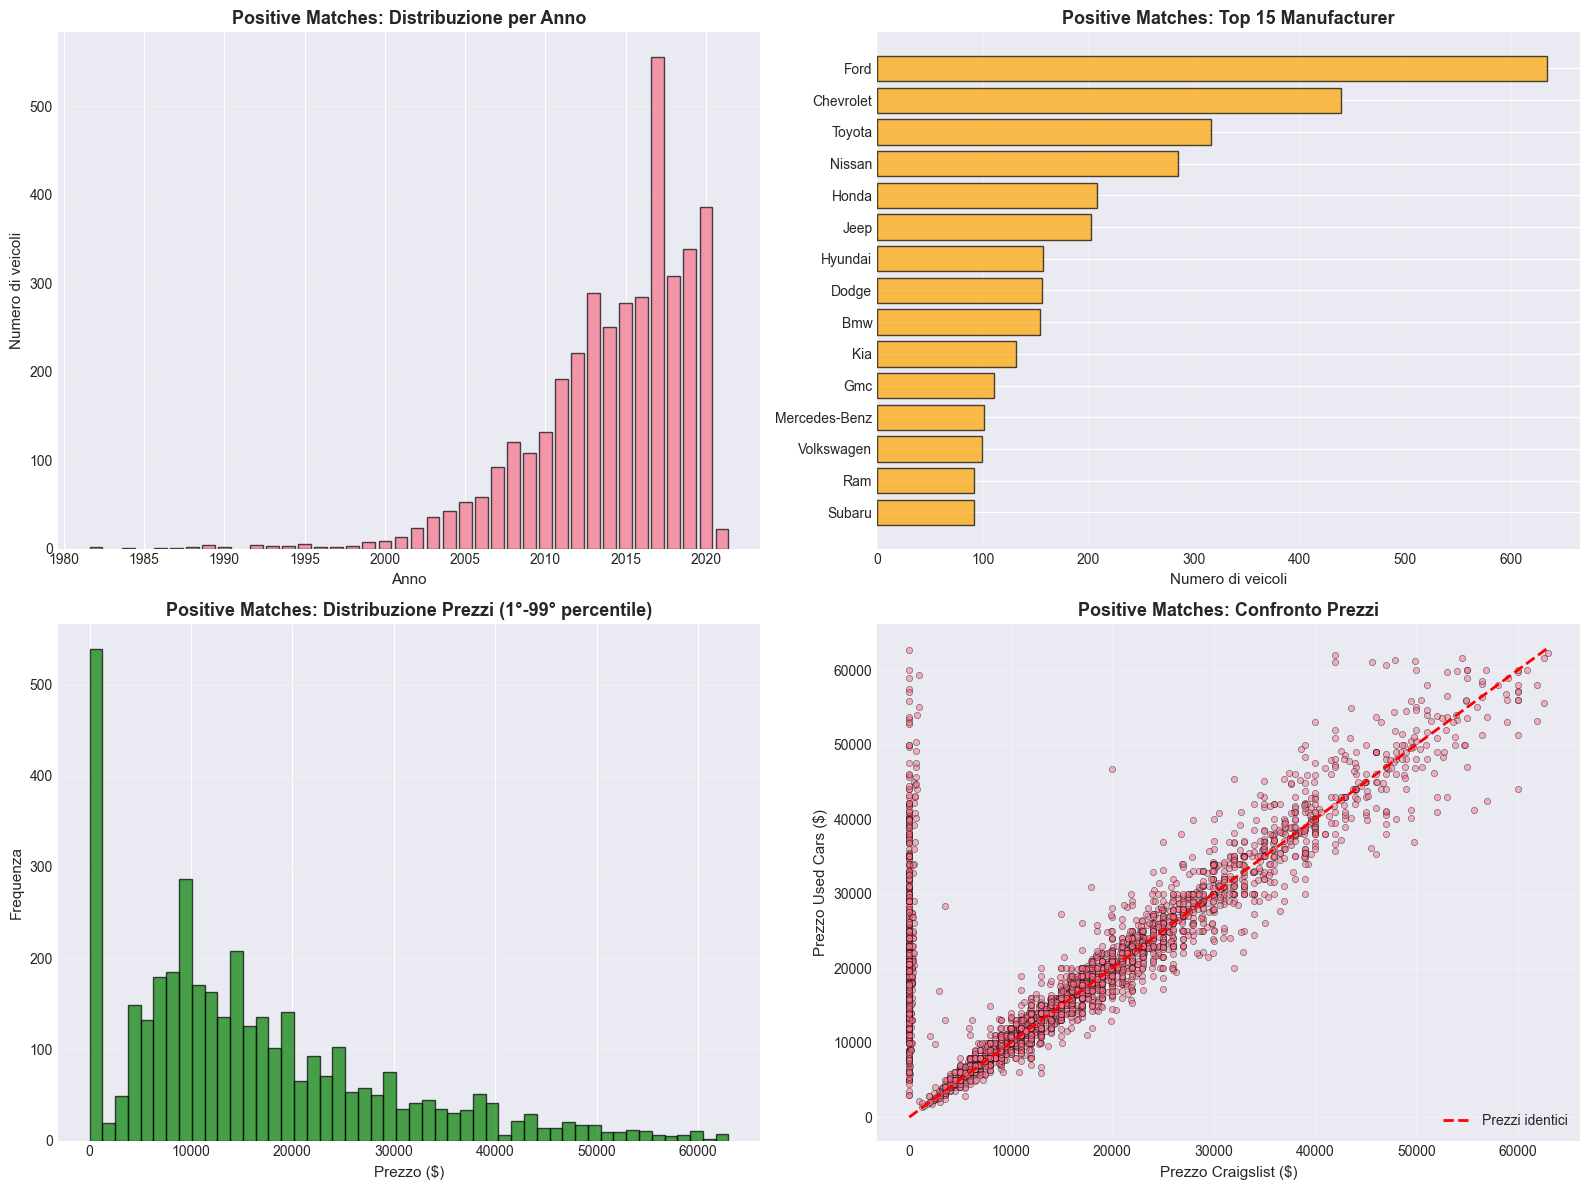

In [15]:
if len(matches) > 0:
    # Visualizzazioni (POSITIVE MATCHES)
    df_positive = pd.DataFrame(matches)
    fig, axes = plt.subplots(2, 2, figsize=(16, 12))
    
    # 1. Distribuzione per anno
    ax1 = axes[0, 0]
    year_counts = df_positive['year'].value_counts().sort_index()
    ax1.bar(year_counts.index, year_counts.values, edgecolor='black', alpha=0.7)
    ax1.set_xlabel('Anno', fontsize=11)
    ax1.set_ylabel('Numero di veicoli', fontsize=11)
    ax1.set_title('Positive Matches: Distribuzione per Anno', fontsize=13, fontweight='bold')
    ax1.grid(axis='y', alpha=0.3)
    
    # 2. Distribuzione per manufacturer (top 15)
    ax2 = axes[0, 1]
    manuf_top = df_positive['manufacturer_cr'].value_counts().head(15)
    ax2.barh(range(len(manuf_top)), manuf_top.values, edgecolor='black', alpha=0.7, color='orange')
    ax2.set_yticks(range(len(manuf_top)))
    ax2.set_yticklabels(manuf_top.index)
    ax2.set_xlabel('Numero di veicoli', fontsize=11)
    ax2.set_title('Positive Matches: Top 15 Manufacturer', fontsize=13, fontweight='bold')
    ax2.grid(axis='x', alpha=0.3)
    ax2.invert_yaxis()
    
    # 3. Distribuzione prezzi
    ax3 = axes[1, 0]
    # Rimuovi outlier estremi per visualizzazione
    prices = df_positive['price_cr'].dropna()
    q1, q99 = prices.quantile([0.01, 0.99])
    prices_filtered = prices[(prices >= q1) & (prices <= q99)]
    ax3.hist(prices_filtered, bins=50, edgecolor='black', alpha=0.7, color='green')
    ax3.set_xlabel('Prezzo ($)', fontsize=11)
    ax3.set_ylabel('Frequenza', fontsize=11)
    ax3.set_title('Positive Matches: Distribuzione Prezzi (1°-99° percentile)', fontsize=13, fontweight='bold')
    ax3.grid(axis='y', alpha=0.3)
    
    # 4. Confronto prezzi Craigslist vs Used Cars
    ax4 = axes[1, 1]
    valid_prices = df_positive[['price_cr', 'price_uc']].dropna()
    # Filtra outlier
    mask = (valid_prices['price_cr'] < q99) & (valid_prices['price_uc'] < q99)
    valid_prices_filtered = valid_prices[mask]
    
    ax4.scatter(valid_prices_filtered['price_cr'], valid_prices_filtered['price_uc'], 
                alpha=0.5, s=20, edgecolors='black', linewidth=0.5)
    
    # Linea di riferimento (prezzi identici)
    max_price = max(valid_prices_filtered['price_cr'].max(), valid_prices_filtered['price_uc'].max())
    ax4.plot([0, max_price], [0, max_price], 'r--', linewidth=2, label='Prezzi identici')
    
    ax4.set_xlabel('Prezzo Craigslist ($)', fontsize=11)
    ax4.set_ylabel('Prezzo Used Cars ($)', fontsize=11)
    ax4.set_title('Positive Matches: Confronto Prezzi', fontsize=13, fontweight='bold')
    ax4.legend()
    ax4.grid(alpha=0.3)
    
    plt.tight_layout()
    plt.show()
else:
    print("Nessuna visualizzazione da generare.")

## 6. Train/Validation/Test Split

Dividiamo il dataset in:
- **Train (70%)**: Per addestrare modelli ML
- **Validation (15%)**: Per tuning hyperparameter
- **Test (15%)**: Per valutazione finale

**No Data Leakage**: Partizionamento univoco garantito dal shuffle

In [18]:
if len(df_ground_truth_labeled) > 0:
    print("\nTRAIN/VALIDATION/TEST SPLIT")
    print("=" * 80)
    
    # Shuffle del dataset per randomizzare
    df_shuffled = df_ground_truth_labeled.sample(frac=1, random_state=42).reset_index(drop=True)
    
    total_size = len(df_shuffled)
    train_size = int(0.7 * total_size)
    val_size = int(0.15 * total_size)
    # test_size è il resto
    
    # Split
    df_train = df_shuffled.iloc[:train_size].copy()
    df_val = df_shuffled.iloc[train_size:train_size+val_size].copy()
    df_test = df_shuffled.iloc[train_size+val_size:].copy()
    
    print(f"\nDimensioni dataset:")
    print(f"  TOTALE: {total_size:,} coppie")
    print(f"\n  TRAIN (70%): {len(df_train):,} coppie")
    print(f"    - Positive: {(df_train['label'] == 1).sum():,} ({(df_train['label'] == 1).sum()/len(df_train)*100:.1f}%)")
    print(f"    - Negative: {(df_train['label'] == 0).sum():,} ({(df_train['label'] == 0).sum()/len(df_train)*100:.1f}%)")
    
    print(f"\n  VALIDATION (15%): {len(df_val):,} coppie")
    print(f"    - Positive: {(df_val['label'] == 1).sum():,} ({(df_val['label'] == 1).sum()/len(df_val)*100:.1f}%)")
    print(f"    - Negative: {(df_val['label'] == 0).sum():,} ({(df_val['label'] == 0).sum()/len(df_val)*100:.1f}%)")
    
    print(f"\n  TEST (15%): {len(df_test):,} coppie")
    print(f"    - Positive: {(df_test['label'] == 1).sum():,} ({(df_test['label'] == 1).sum()/len(df_test)*100:.1f}%)")
    print(f"    - Negative: {(df_test['label'] == 0).sum():,} ({(df_test['label'] == 0).sum()/len(df_test)*100:.1f}%)")
    
    # Verifica no data leakage
    train_ids = set(zip(df_train['craigslist_id'], df_train['used_cars_id']))
    val_ids = set(zip(df_val['craigslist_id'], df_val['used_cars_id']))
    test_ids = set(zip(df_test['craigslist_id'], df_test['used_cars_id']))
    
    overlap_train_val = len(train_ids.intersection(val_ids))
    overlap_train_test = len(train_ids.intersection(test_ids))
    overlap_val_test = len(val_ids.intersection(test_ids))
    
    print(f"\n✅ Verifica No Data Leakage:")
    print(f"   Train ∩ Validation: {overlap_train_val} coppie")
    print(f"   Train ∩ Test: {overlap_train_test} coppie")
    print(f"   Validation ∩ Test: {overlap_val_test} coppie")
    
    if overlap_train_val == 0 and overlap_train_test == 0 and overlap_val_test == 0:
        print(f"   ✓ Nessun overlap - Split corretto!")
    else:
        print(f"   ⚠️  WARNING: Rilevato overlap tra split!")
    
else:
    print("Nessun dataset da splittare.")
    df_train = df_val = df_test = pd.DataFrame()


TRAIN/VALIDATION/TEST SPLIT

Dimensioni dataset:
  TOTALE: 15,412 coppie

  TRAIN (70%): 10,788 coppie
    - Positive: 2,724 (25.3%)
    - Negative: 8,064 (74.7%)

  VALIDATION (15%): 2,311 coppie
    - Positive: 548 (23.7%)
    - Negative: 1,763 (76.3%)

  TEST (15%): 2,313 coppie
    - Positive: 581 (25.1%)
    - Negative: 1,732 (74.9%)

✅ Verifica No Data Leakage:
   Train ∩ Validation: 0 coppie
   Train ∩ Test: 0 coppie
   Validation ∩ Test: 0 coppie
   ✓ Nessun overlap - Split corretto!


## 7. Creazione Dataset ML (No-VIN)

Creiamo dataset **senza la colonna VIN** per il training ML.

**Obiettivo**: Il modello deve imparare a matchare basandosi su attributi "fuzzy" (year, model, price, mileage) 
e NON banalmente sul VIN.

In [19]:
if len(df_train) > 0:
    print("CREAZIONE DATASET ML (NO-VIN)")
    print("=" * 80)
    
    # Raccogli tutti gli ID coinvolti nei split
    all_cr_ids = set()
    all_uc_ids = set()
    
    for df in [df_train, df_val, df_test]:
        all_cr_ids.update(df['craigslist_id'].dropna())
        all_uc_ids.update(df['used_cars_id'].dropna())
    
    print(f"\nID univoci coinvolti nel ground-truth:")
    print(f"  Craigslist: {len(all_cr_ids):,} record")
    print(f"  Used Cars: {len(all_uc_ids):,} record")
    
    # Filtra dataset deduplicati per includere solo record coinvolti (SCHEMA ALLINEATO usa 'vehicle_id')
    df_cr_no_vin = df_craigslist_dedup[df_craigslist_dedup['vehicle_id'].isin(all_cr_ids)].copy()
    df_uc_no_vin = df_used_cars_dedup[df_used_cars_dedup['vehicle_id'].isin(all_uc_ids)].copy()
    
    # RIMUOVI colonna VIN e vin_clean (nei dataset allineati la colonna è 'vin')
    columns_to_drop = ['vin', 'vin_clean']
    
    df_cr_no_vin = df_cr_no_vin.drop(columns=[col for col in columns_to_drop if col in df_cr_no_vin.columns])
    df_uc_no_vin = df_uc_no_vin.drop(columns=[col for col in columns_to_drop if col in df_uc_no_vin.columns])
    
    print(f"\nDataset ML (senza VIN):")
    print(f"  dataset_A_no_vin.csv (Craigslist): {len(df_cr_no_vin):,} righe × {len(df_cr_no_vin.columns)} colonne")
    print(f"  dataset_B_no_vin.csv (Used Cars): {len(df_uc_no_vin):,} righe × {len(df_uc_no_vin.columns)} colonne")
    
    print(f"\n✅ Colonna VIN rimossa da entrambi i dataset")
    print(f"   I modelli ML dovranno imparare a matchare su attributi fuzzy:")
    print(f"   - year, manufacturer, model")
    print(f"   - price, mileage")
    print(f"   - fuel, transmission, drive")
    print(f"   - latitude, longitude, location")
    
else:
    print("Nessun dataset ML da creare.")
    df_cr_no_vin = df_uc_no_vin = pd.DataFrame()

CREAZIONE DATASET ML (NO-VIN)

ID univoci coinvolti nel ground-truth:
  Craigslist: 14,492 record
  Used Cars: 15,375 record

Dataset ML (senza VIN):
  dataset_A_no_vin.csv (Craigslist): 14,492 righe × 19 colonne
  dataset_B_no_vin.csv (Used Cars): 15,375 righe × 19 colonne

✅ Colonna VIN rimossa da entrambi i dataset
   I modelli ML dovranno imparare a matchare su attributi fuzzy:
   - year, manufacturer, model
   - price, mileage
   - fuel, transmission, drive
   - latitude, longitude, location


In [20]:
import os

if len(df_ground_truth_labeled) > 0:
    # Crea cartella per ground-truth
    os.makedirs('ground_truth', exist_ok=True)
    
    print("SALVATAGGIO GROUND-TRUTH E DATASET ML")
    print("=" * 80)
    
    # 1. Salva Train/Val/Test splits
    print("\n1. Salvataggio Train/Validation/Test splits...")
    df_train.to_csv('ground_truth/train.csv', index=False)
    df_val.to_csv('ground_truth/validation.csv', index=False)
    df_test.to_csv('ground_truth/test.csv', index=False)
    print(f"   ✓ ground_truth/train.csv ({len(df_train):,} coppie)")
    print(f"   ✓ ground_truth/validation.csv ({len(df_val):,} coppie)")
    print(f"   ✓ ground_truth/test.csv ({len(df_test):,} coppie)")
    
    # 2. Salva dataset completo (POSITIVI + NEGATIVI CON LABEL)
    print("\n2. Salvataggio dataset completo con positivi E negativi...")
    df_ground_truth_labeled.to_csv('ground_truth/ground_truth_complete.csv', index=False)
    print(f"   ✓ ground_truth/ground_truth_complete.csv ({len(df_ground_truth_labeled):,} coppie)")
    print(f"     - Positive (label=1): {(df_ground_truth_labeled['label']==1).sum():,}")
    print(f"     - Negative (label=0): {(df_ground_truth_labeled['label']==0).sum():,}")
    
    # 3. Salva dataset ML (NO-VIN)
    print("\n3. Salvataggio dataset ML (senza VIN)...")
    df_cr_no_vin.to_csv('ground_truth/dataset_A_no_vin.csv', index=False)
    df_uc_no_vin.to_csv('ground_truth/dataset_B_no_vin.csv', index=False)
    print(f"   ✓ ground_truth/dataset_A_no_vin.csv ({len(df_cr_no_vin):,} righe)")
    print(f"   ✓ ground_truth/dataset_B_no_vin.csv ({len(df_uc_no_vin):,} righe)")
    
    # 4. Salva mapping ID SOLO positivi
    df_positive_only = df_ground_truth_labeled[df_ground_truth_labeled['label'] == 1]
    df_ids = df_positive_only[['vin', 'craigslist_id', 'used_cars_id']]
    df_ids.to_csv('ground_truth/positive_matches_mapping.csv', index=False)
    print(f"\n4. Mapping solo match positivi...")
    print(f"   ✓ ground_truth/positive_matches_mapping.csv ({len(df_ids):,} coppie)")
    
    # 5. Salva metadati completi
    print("\n5. Salvataggio metadati...")
    
    # Usa df_positive_only per statistiche (solo positivi validati)
    metadata = {
        'creation_date': datetime.now().strftime('%Y-%m-%d %H:%M:%S'),
        'strategy': 'VIN-based matching with deduplication, anti-noise filter, and negative sampling',
        'deduplication': {
            'craigslist_before': len(df_craigslist),
            'craigslist_after': len(df_craigslist_dedup),
            'craigslist_duplicates_removed': len(df_craigslist) - len(df_craigslist_dedup),
            'used_cars_before': len(df_used_cars),
            'used_cars_after': len(df_used_cars_dedup),
            'used_cars_duplicates_removed': len(df_used_cars) - len(df_used_cars_dedup)
        },
        'ground_truth_labeled': {
            'total_pairs': len(df_ground_truth_labeled),
            'positive_pairs': int((df_ground_truth_labeled['label'] == 1).sum()),
            'negative_pairs': int((df_ground_truth_labeled['label'] == 0).sum()),
            'negative_ratio': f"{int((df_ground_truth_labeled['label'] == 0).sum() / (df_ground_truth_labeled['label'] == 1).sum())}:1"
        },
        'datasets_coverage': {
            'craigslist': {
                'total_records': len(df_craigslist),
                'records_with_valid_vin': len(vins_craigslist),
                'records_in_ground_truth': len(df_cr_no_vin)
            },
            'used_cars': {
                'total_records': len(df_used_cars),
                'records_with_valid_vin': len(vins_used_cars),
                'records_in_ground_truth': len(df_uc_no_vin)
            }
        },
        'validation_criteria': {
            'year_matching': 'exact',
            'manufacturer_matching': 'substring (anti-noise filter)',
            'price_tolerance': '±$5000 or ±50%',
            'mileage_tolerance': '±10000 miles or ±20%'
        },
        'statistics_positive_matches': {
            'unique_manufacturers': int(df_positive_only['manufacturer_cr'].nunique()),
            'year_range': [int(df_positive_only['year'].min()), int(df_positive_only['year'].max())],
            'price_range_cr': [float(df_positive_only['price_cr'].min()), float(df_positive_only['price_cr'].max())],
            'mileage_range_cr': [float(df_positive_only['mileage_cr'].min()), float(df_positive_only['mileage_cr'].max())],
            'matches_with_warnings': int((df_positive_only['warnings'] > 0).sum()),
            'perfect_matches': int((df_positive_only['warnings'] == 0).sum())
        }
    }
    
    with open('ground_truth/metadata.json', 'w', encoding='utf-8') as f:
        json.dump(metadata, f, indent=2, ensure_ascii=False)
    print(f"   ✓ ground_truth/metadata.json")
    
    # 6. Genera report testuale
    timestamp = datetime.now().strftime("%Y%m%d_%H%M%S")
    report_file = f'ground_truth/report_{timestamp}.txt'
    
    with open(report_file, 'w', encoding='utf-8') as f:
        f.write("=" * 100 + "\n")
        f.write("GROUND-TRUTH GENERATION REPORT\n")
        f.write(f"Generato il: {datetime.now().strftime('%Y-%m-%d %H:%M:%S')}\n")
        f.write("=" * 100 + "\n\n")
        
        f.write("1. DATI SORGENTE\n")
        f.write("-" * 100 + "\n")
        f.write(f"Dataset Craigslist: {len(df_craigslist):,} righe\n")
        f.write(f"  - VIN validi: {len(vins_craigslist):,} ({len(vins_craigslist)/len(df_craigslist)*100:.1f}%)\n")
        f.write(f"Dataset Used Cars: {len(df_used_cars):,} righe\n")
        f.write(f"  - VIN validi: {len(vins_used_cars):,} ({len(vins_used_cars)/len(df_used_cars)*100:.1f}%)\n")
        f.write(f"\nVIN comuni identificati: {len(common_vins):,}\n\n")
        
        f.write("2. VALIDAZIONE E NEGATIVE SAMPLING\n")
        f.write("-" * 100 + "\n")
        f.write(f"Match validati: {len(matches):,}\n")
        f.write(f"Match validi (positivi): {valid_matches:,}\n")
        f.write(f"Match non validi: {invalid_matches:,}\n")
        f.write(f"\nNegative matches generati: {(df_ground_truth_labeled['label']==0).sum():,}\n")
        f.write(f"Ratio negativo:positivo: {int((df_ground_truth_labeled['label']==0).sum()/valid_matches)}:1\n\n")
        
        f.write("3. GROUND-TRUTH FINALE\n")
        f.write("-" * 100 + "\n")
        f.write(f"Totale coppie labeled: {len(df_ground_truth_labeled):,}\n")
        f.write(f"  - Positive (label=1): {(df_ground_truth_labeled['label']==1).sum():,}\n")
        f.write(f"  - Negative (label=0): {(df_ground_truth_labeled['label']==0).sum():,}\n\n")
        
        f.write("4. STATISTICHE POSITIVE MATCHES\n")
        f.write("-" * 100 + "\n")
        f.write(f"Manufacturer unici: {df_positive_only['manufacturer_cr'].nunique()}\n")
        f.write(f"Anni coperti: {df_positive_only['year'].min():.0f} - {df_positive_only['year'].max():.0f}\n")
        f.write(f"Range prezzo (Craigslist): ${df_positive_only['price_cr'].min():,.0f} - ${df_positive_only['price_cr'].max():,.0f}\n")
        f.write(f"Range mileage (Craigslist): {df_positive_only['mileage_cr'].min():,.0f} - {df_positive_only['mileage_cr'].max():,.0f} miglia\n")
        f.write(f"\nMatch perfetti (no warnings): {(df_positive_only['warnings'] == 0).sum():,}\n")
        f.write(f"Match con warnings: {(df_positive_only['warnings'] > 0).sum():,}\n\n")
        
        f.write("5. TOP 10 MANUFACTURER (POSITIVE MATCHES)\n")
        f.write("-" * 100 + "\n")
        top_manuf = df_positive_only['manufacturer_cr'].value_counts().head(10)
        for manuf, count in top_manuf.items():
            f.write(f"{manuf:20s}: {count:5,} ({count/len(df_positive_only)*100:5.1f}%)\n")
    
    print(f"   ✓ {report_file}")
    
    print("\n" + "=" * 80)
    print("✅ COMPLETATO!")
    print("=" * 80)
    print("\nFile generati:")
    print("  📁 ground_truth/train.csv - Train set (60%) con label")
    print("  📁 ground_truth/validation.csv - Validation set (20%) con label")
    print("  📁 ground_truth/test.csv - Test set (20%) con label")
    print("  📁 ground_truth/ground_truth_complete.csv - POSITIVI + NEGATIVI con label")
    print("  📁 ground_truth/dataset_A_no_vin.csv - Craigslist senza VIN")
    print("  📁 ground_truth/dataset_B_no_vin.csv - Used Cars senza VIN")
    print("  📁 ground_truth/positive_matches_mapping.csv - Solo match positivi")
    print("  📁 ground_truth/metadata.json - Metadati completi")
    print(f"  📁 {report_file}")
    
else:
    print("\n❌ IMPOSSIBILE GENERARE GROUND-TRUTH")
    print("\nNessun match trovato o dataset vuoto.")
    print("\nStrategie alternative:")
    print("  1. Matching probabilistico basato su (year, manufacturer, model, price)")
    print("  2. Validazione manuale di un campione")
    print("  3. Acquisizione di dati esterni con VIN")
    print("  4. Utilizzo di regole di business per identificare match probabili")

SALVATAGGIO GROUND-TRUTH E DATASET ML

1. Salvataggio Train/Validation/Test splits...
   ✓ ground_truth/train.csv (10,788 coppie)
   ✓ ground_truth/validation.csv (2,311 coppie)
   ✓ ground_truth/test.csv (2,313 coppie)

2. Salvataggio dataset completo con positivi E negativi...
   ✓ ground_truth/ground_truth_complete.csv (15,412 coppie)
     - Positive (label=1): 3,853
     - Negative (label=0): 11,559

3. Salvataggio dataset ML (senza VIN)...
   ✓ ground_truth/dataset_A_no_vin.csv (14,492 righe)
   ✓ ground_truth/dataset_B_no_vin.csv (15,375 righe)

4. Mapping solo match positivi...
   ✓ ground_truth/positive_matches_mapping.csv (3,853 coppie)

5. Salvataggio metadati...
   ✓ ground_truth/metadata.json
   ✓ ground_truth/report_20260202_105225.txt

✅ COMPLETATO!

File generati:
  📁 ground_truth/train.csv - Train set (60%) con label
  📁 ground_truth/validation.csv - Validation set (20%) con label
  📁 ground_truth/test.csv - Test set (20%) con label
  📁 ground_truth/ground_truth_complet

## 8. Valutazione Qualità Ground-Truth

Verifichiamo la qualità del ground-truth generato attraverso metriche chiave:
- **Balance**: Distribuzione positivi/negativi
- **Coverage**: Rappresentatività manufacturer, anni, prezzi
- **Consistency**: Coerenza degli attributi nei positive matches
- **Size**: Dimensione adeguata per training ML


VALUTAZIONE QUALITÀ GROUND-TRUTH

1. BALANCE E DIMENSIONE
----------------------------------------------------------------------------------------------------
Totale coppie: 15,412
  Positive (label=1): 3,853 (25.0%)
  Negative (label=0): 11,559 (75.0%)
  Ratio negativo:positivo: 3.0:1

  Qualità Balance: ✅ OTTIMO
  Ratio ideale per training ML

  Qualità Dimensione: ✅ OTTIMO
  15,412 coppie sono sufficienti per training robusto


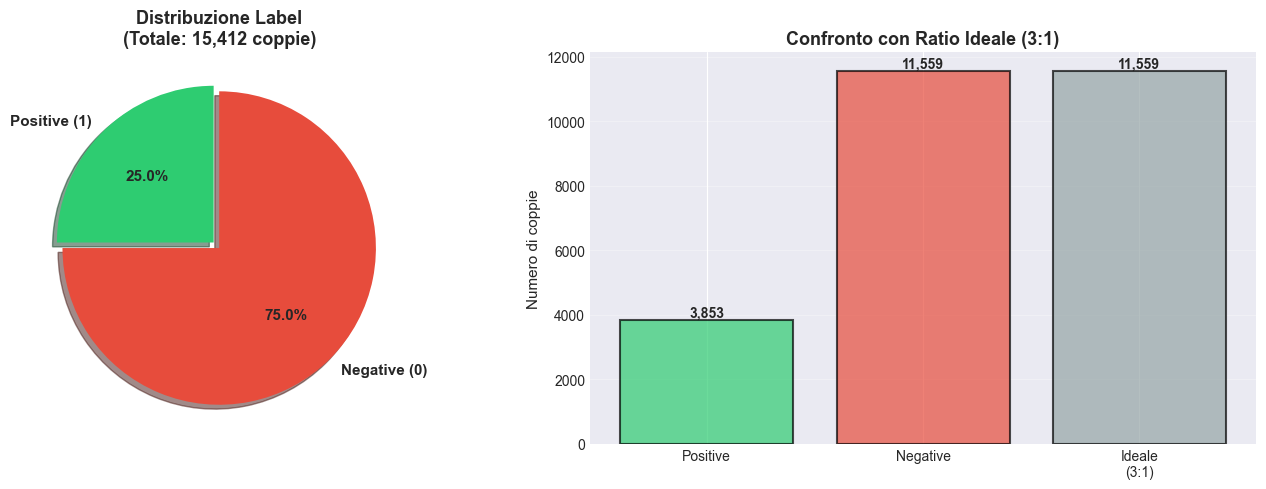


2. COVERAGE E DIVERSITY (Positive Matches)
----------------------------------------------------------------------------------------------------
Manufacturer unici: 36
  Top 5 manufacturer: 48.8% del totale
    Ford: 634 (16.5%)
    Chevrolet: 439 (11.4%)
    Toyota: 316 (8.2%)
    Nissan: 285 (7.4%)
    Honda: 208 (5.4%)

  Qualità Manufacturer: ✅ OTTIMO
  Eccellente diversity di brand


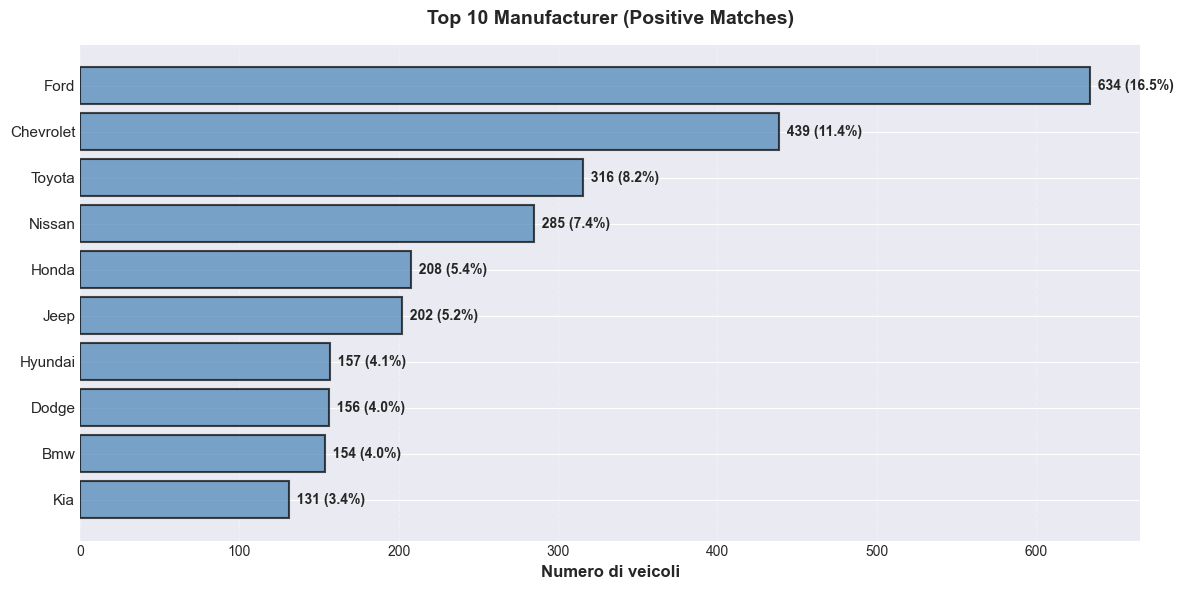


Anni coperti: 1982 - 2021 (range: 39 anni)
  Distribuzione per decade:
    1980s: 11 (0.3%)
    1990s: 31 (0.8%)
    2000s: 554 (14.4%)
    2010s: 2,849 (73.9%)
    2020s: 408 (10.6%)

  Qualità Coverage Temporale: ✅ OTTIMO
  Eccellente coverage temporale


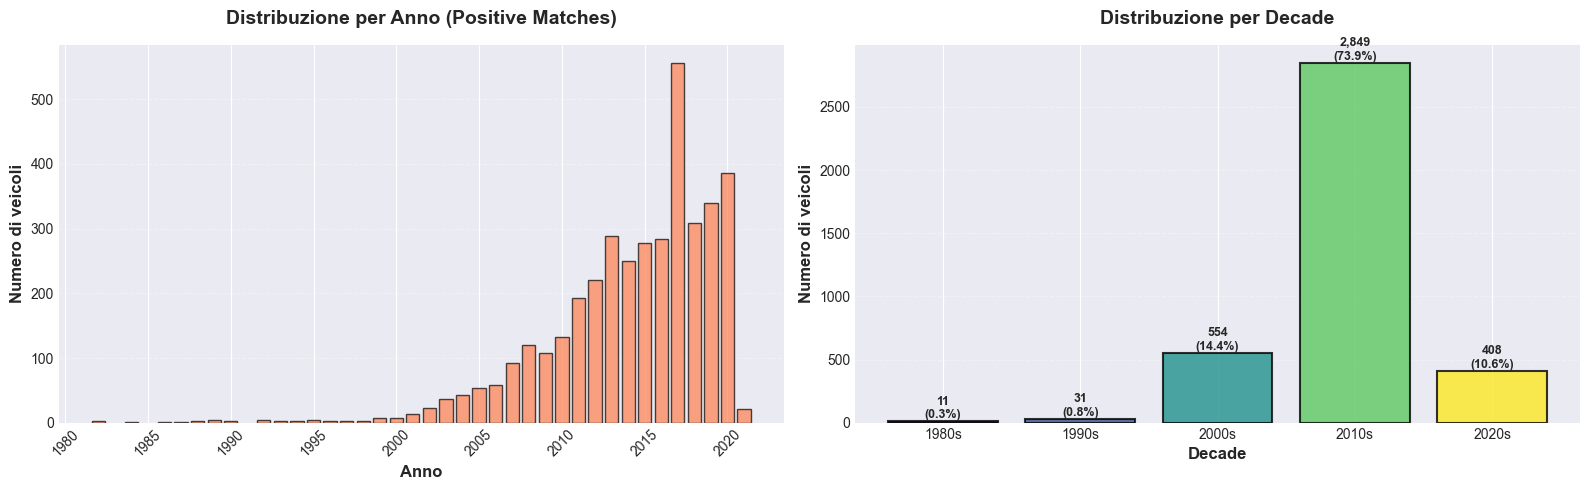


Range prezzi (Craigslist):
  Min: $0
  Mediana: $12,995
  Max: $990,000
  Distribuzione per fasce:
    <$5K: 302 (7.8%)
    $5K-10K: 782 (20.3%)
    $10K-20K: 1,181 (30.7%)
    $20K-50K: 1,019 (26.4%)
    >$50K: 115 (3.0%)


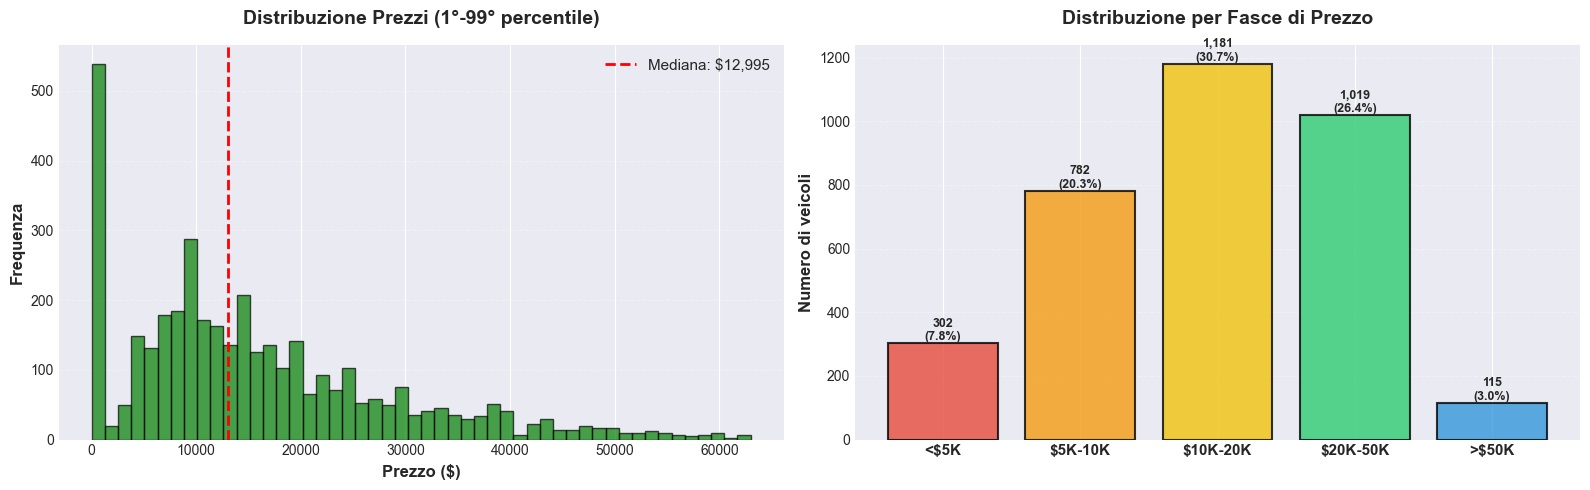


3. CONSISTENCY (Positive Matches)
----------------------------------------------------------------------------------------------------
Match perfetti (no warnings): 3,459 (89.8%)
Match con warnings: 394 (10.2%)

  Qualità Consistency: ✅ OTTIMO
  Elevata coerenza degli attributi

  Analisi warnings:
    5 occorrenze - Model diverso: CR=f150 supercrew cab, UC=f-150...
    5 occorrenze - Model diverso: CR=sport, UC=range rover sport...
    4 occorrenze - Model diverso: CR=f150 supercrew cab xl, UC=f-150...
    4 occorrenze - Model diverso: CR=3-series, UC=3 series...
    4 occorrenze - Model diverso: CR=328i, UC=3 series...


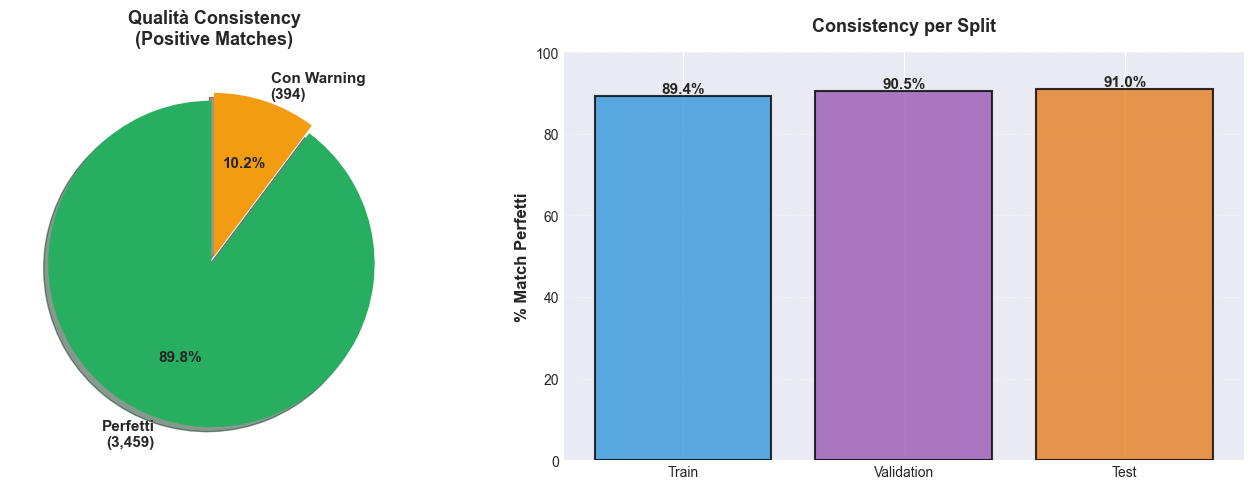


4. DATA QUALITY
----------------------------------------------------------------------------------------------------
Completezza attributi chiave (Positive Matches):
  ✅ Anno: 100.0% completo
  ✅ Manufacturer: 100.0% completo
  ✅ Model: 99.7% completo
  ✅ Prezzo: 100.0% completo
  ✅ Mileage: 99.2% completo

  Qualità Completezza: ✅ OTTIMO
  Media completezza: 99.8%
  Dataset molto completo


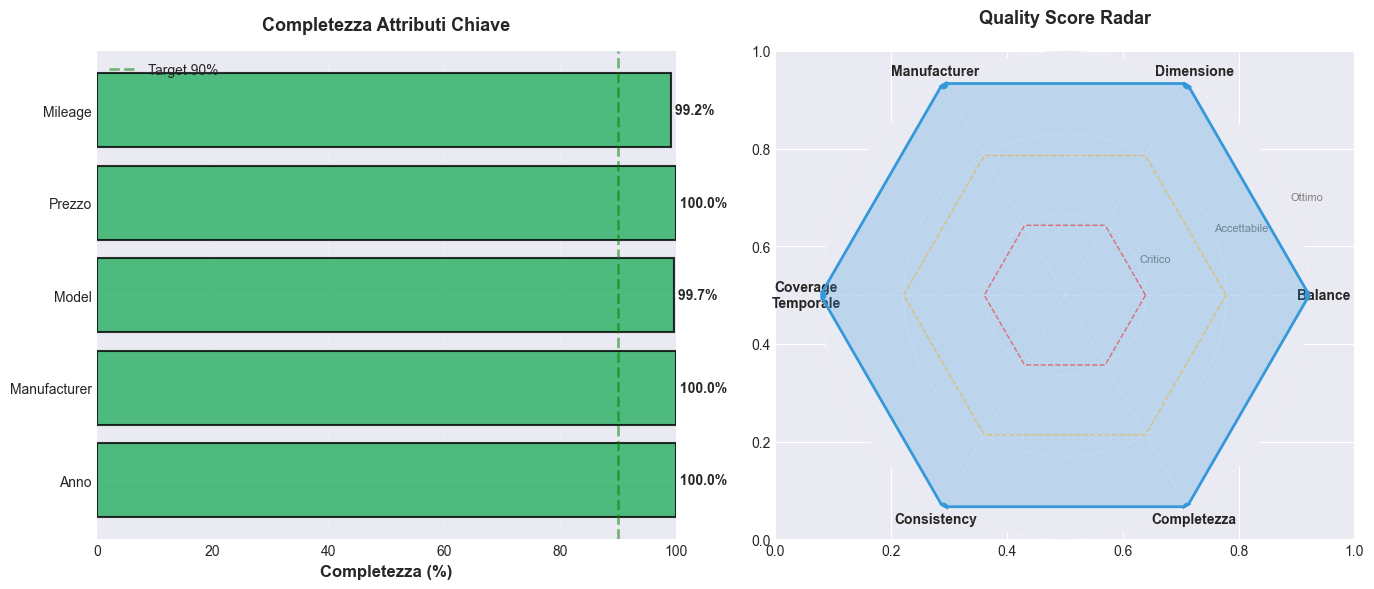


SUMMARY - QUALITÀ COMPLESSIVA GROUND-TRUTH

Metriche valutate: 6
  ✅ Ottime: 6
  ⚠️  Accettabili: 0
  ❌ Critiche: 0

  Balance: ✅ OTTIMO

  Dimensione: ✅ OTTIMO

  Manufacturer Diversity: ✅ OTTIMO

  Coverage Temporale: ✅ OTTIMO

  Consistency: ✅ OTTIMO

  Data Quality: ✅ OTTIMO

----------------------------------------------------------------------------------------------------
RACCOMANDAZIONI:
----------------------------------------------------------------------------------------------------
✅ Ground-truth di ECCELLENTE qualità - pronto per training ML!
   Procedere con:
   - Feature engineering su attributi fuzzy
   - Training modelli supervisionati (RF, XGBoost, NN)
   - Validazione su test set separato



In [22]:
if len(df_ground_truth_labeled) > 0:
    print("\n" + "=" * 100)
    print("VALUTAZIONE QUALITÀ GROUND-TRUTH")
    print("=" * 100)
    
    # Separa positivi e negativi per analisi
    df_pos = df_ground_truth_labeled[df_ground_truth_labeled['label'] == 1]
    df_neg = df_ground_truth_labeled[df_ground_truth_labeled['label'] == 0]
    
    # ========== 1. BALANCE E DIMENSIONE ==========
    print("\n1. BALANCE E DIMENSIONE")
    print("-" * 100)
    total = len(df_ground_truth_labeled)
    n_pos = len(df_pos)
    n_neg = len(df_neg)
    ratio = n_neg / n_pos if n_pos > 0 else 0
    
    print(f"Totale coppie: {total:,}")
    print(f"  Positive (label=1): {n_pos:,} ({n_pos/total*100:.1f}%)")
    print(f"  Negative (label=0): {n_neg:,} ({n_neg/total*100:.1f}%)")
    print(f"  Ratio negativo:positivo: {ratio:.1f}:1")
    
    # Quality score per balance
    if 2 <= ratio <= 5:
        balance_score = "✅ OTTIMO"
        balance_msg = "Ratio ideale per training ML"
    elif 1 <= ratio < 2 or 5 < ratio <= 10:
        balance_score = "⚠️  ACCETTABILE"
        balance_msg = "Ratio utilizzabile ma non ottimale"
    else:
        balance_score = "❌ CRITICO"
        balance_msg = "Dataset fortemente sbilanciato"
    
    print(f"\n  Qualità Balance: {balance_score}")
    print(f"  {balance_msg}")
    
    # Quality score per dimensione
    if total >= 5000:
        size_score = "✅ OTTIMO"
        size_msg = f"{total:,} coppie sono sufficienti per training robusto"
    elif total >= 1000:
        size_score = "⚠️  ACCETTABILE"
        size_msg = f"{total:,} coppie possono richiedere data augmentation"
    else:
        size_score = "❌ CRITICO"
        size_msg = f"{total:,} coppie sono insufficienti - serve espansione dataset"
    
    print(f"\n  Qualità Dimensione: {size_score}")
    print(f"  {size_msg}")
    
    # GRAFICO: Balance Positivi/Negativi
    fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(14, 5))
    
    # Pie chart - Distribuzione label
    labels_pie = ['Positive (1)', 'Negative (0)']
    sizes = [n_pos, n_neg]
    colors = ['#2ecc71', '#e74c3c']
    explode = (0.05, 0)
    
    ax1.pie(sizes, explode=explode, labels=labels_pie, colors=colors, autopct='%1.1f%%',
            shadow=True, startangle=90, textprops={'fontsize': 11, 'weight': 'bold'})
    ax1.set_title(f'Distribuzione Label\n(Totale: {total:,} coppie)', fontsize=13, fontweight='bold')
    
    # Bar chart - Confronto con target ideale
    categories = ['Positive', 'Negative', 'Ideale\n(3:1)']
    values = [n_pos, n_neg, n_pos * 3]
    colors_bar = ['#2ecc71', '#e74c3c', '#95a5a6']
    
    bars = ax2.bar(categories, values, color=colors_bar, alpha=0.7, edgecolor='black', linewidth=1.5)
    ax2.set_ylabel('Numero di coppie', fontsize=11)
    ax2.set_title('Confronto con Ratio Ideale (3:1)', fontsize=13, fontweight='bold')
    ax2.grid(axis='y', alpha=0.3)
    
    # Aggiungi valori sopra le barre
    for bar in bars:
        height = bar.get_height()
        ax2.text(bar.get_x() + bar.get_width()/2., height,
                f'{int(height):,}',
                ha='center', va='bottom', fontsize=10, fontweight='bold')
    
    plt.tight_layout()
    plt.show()
    
    # ========== 2. COVERAGE E DIVERSITY ==========
    print("\n2. COVERAGE E DIVERSITY (Positive Matches)")
    print("-" * 100)
    
    # Manufacturer
    n_manufacturers = df_pos['manufacturer_cr'].nunique()
    top5_manuf = df_pos['manufacturer_cr'].value_counts().head(5)
    top5_coverage = top5_manuf.sum() / len(df_pos) * 100
    
    print(f"Manufacturer unici: {n_manufacturers}")
    print(f"  Top 5 manufacturer: {top5_coverage:.1f}% del totale")
    for manuf, count in top5_manuf.items():
        print(f"    {manuf}: {count:,} ({count/len(df_pos)*100:.1f}%)")
    
    if n_manufacturers >= 20:
        manuf_score = "✅ OTTIMO"
        manuf_msg = "Eccellente diversity di brand"
    elif n_manufacturers >= 10:
        manuf_score = "⚠️  ACCETTABILE"
        manuf_msg = "Diversity sufficiente ma limitata"
    else:
        manuf_score = "❌ CRITICO"
        manuf_msg = "Coverage troppo limitata - rischio bias"
    
    print(f"\n  Qualità Manufacturer: {manuf_score}")
    print(f"  {manuf_msg}")
    
    # GRAFICO: Top Manufacturers
    fig, ax = plt.subplots(figsize=(12, 6))
    top10_manuf = df_pos['manufacturer_cr'].value_counts().head(10)
    
    bars = ax.barh(range(len(top10_manuf)), top10_manuf.values, 
                   color='steelblue', alpha=0.7, edgecolor='black', linewidth=1.5)
    ax.set_yticks(range(len(top10_manuf)))
    ax.set_yticklabels(top10_manuf.index, fontsize=11)
    ax.set_xlabel('Numero di veicoli', fontsize=12, fontweight='bold')
    ax.set_title('Top 10 Manufacturer (Positive Matches)', fontsize=14, fontweight='bold', pad=15)
    ax.grid(axis='x', alpha=0.3, linestyle='--')
    ax.invert_yaxis()
    
    # Aggiungi valori e percentuali
    for i, (bar, value) in enumerate(zip(bars, top10_manuf.values)):
        percentage = value / len(df_pos) * 100
        ax.text(value, i, f'  {value:,} ({percentage:.1f}%)', 
                va='center', fontsize=10, fontweight='bold')
    
    plt.tight_layout()
    plt.show()
    
    # Anni
    year_min = df_pos['year'].min()
    year_max = df_pos['year'].max()
    year_range = year_max - year_min
    year_coverage = df_pos['year'].value_counts()
    
    print(f"\nAnni coperti: {year_min:.0f} - {year_max:.0f} (range: {year_range:.0f} anni)")
    print(f"  Distribuzione per decade:")
    for decade in range(int(year_min//10*10), int(year_max//10*10)+10, 10):
        count = ((df_pos['year'] >= decade) & (df_pos['year'] < decade+10)).sum()
        if count > 0:
            print(f"    {decade}s: {count:,} ({count/len(df_pos)*100:.1f}%)")
    
    if year_range >= 20:
        year_score = "✅ OTTIMO"
        year_msg = "Eccellente coverage temporale"
    elif year_range >= 10:
        year_score = "⚠️  ACCETTABILE"
        year_msg = "Coverage temporale sufficiente"
    else:
        year_score = "❌ CRITICO"
        year_msg = "Coverage temporale troppo limitata"
    
    print(f"\n  Qualità Coverage Temporale: {year_score}")
    print(f"  {year_msg}")
    
    # GRAFICO: Distribuzione temporale
    fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(16, 5))
    
    # Distribuzione per anno
    year_counts = df_pos['year'].value_counts().sort_index()
    ax1.bar(year_counts.index, year_counts.values, 
            color='coral', alpha=0.7, edgecolor='black', linewidth=1)
    ax1.set_xlabel('Anno', fontsize=12, fontweight='bold')
    ax1.set_ylabel('Numero di veicoli', fontsize=12, fontweight='bold')
    ax1.set_title('Distribuzione per Anno (Positive Matches)', fontsize=14, fontweight='bold', pad=15)
    ax1.grid(axis='y', alpha=0.3, linestyle='--')
    ax1.tick_params(axis='x', rotation=45)
    
    # Distribuzione per decade
    decade_data = {}
    for decade in range(int(year_min//10*10), int(year_max//10*10)+10, 10):
        count = ((df_pos['year'] >= decade) & (df_pos['year'] < decade+10)).sum()
        if count > 0:
            decade_data[f"{decade}s"] = count
    
    decades = list(decade_data.keys())
    counts = list(decade_data.values())
    colors_decade = plt.cm.viridis(np.linspace(0, 1, len(decades)))
    
    bars = ax2.bar(decades, counts, color=colors_decade, alpha=0.8, edgecolor='black', linewidth=1.5)
    ax2.set_xlabel('Decade', fontsize=12, fontweight='bold')
    ax2.set_ylabel('Numero di veicoli', fontsize=12, fontweight='bold')
    ax2.set_title('Distribuzione per Decade', fontsize=14, fontweight='bold', pad=15)
    ax2.grid(axis='y', alpha=0.3, linestyle='--')
    
    # Aggiungi valori sopra le barre
    for bar, count in zip(bars, counts):
        height = bar.get_height()
        ax2.text(bar.get_x() + bar.get_width()/2., height,
                f'{count:,}\n({count/len(df_pos)*100:.1f}%)',
                ha='center', va='bottom', fontsize=9, fontweight='bold')
    
    plt.tight_layout()
    plt.show()
    
    # Prezzi
    price_valid = df_pos['price_cr'].dropna()
    if len(price_valid) > 0:
        price_min = price_valid.min()
        price_max = price_valid.max()
        price_median = price_valid.median()
        
        print(f"\nRange prezzi (Craigslist):")
        print(f"  Min: ${price_min:,.0f}")
        print(f"  Mediana: ${price_median:,.0f}")
        print(f"  Max: ${price_max:,.0f}")
        
        # Fasce di prezzo
        bins = [0, 5000, 10000, 20000, 50000, float('inf')]
        labels = ['<$5K', '$5K-10K', '$10K-20K', '$20K-50K', '>$50K']
        price_brackets = pd.cut(price_valid, bins=bins, labels=labels)
        print(f"  Distribuzione per fasce:")
        for label in labels:
            count = (price_brackets == label).sum()
            if count > 0:
                print(f"    {label}: {count:,} ({count/len(price_valid)*100:.1f}%)")
        
        # GRAFICO: Distribuzione prezzi
        fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(16, 5))
        
        # Histogram con percentili
        q1, q99 = price_valid.quantile([0.01, 0.99])
        price_filtered = price_valid[(price_valid >= q1) & (price_valid <= q99)]
        
        ax1.hist(price_filtered, bins=50, color='green', alpha=0.7, edgecolor='black', linewidth=1)
        ax1.axvline(price_median, color='red', linestyle='--', linewidth=2, label=f'Mediana: ${price_median:,.0f}')
        ax1.set_xlabel('Prezzo ($)', fontsize=12, fontweight='bold')
        ax1.set_ylabel('Frequenza', fontsize=12, fontweight='bold')
        ax1.set_title('Distribuzione Prezzi (1°-99° percentile)', fontsize=14, fontweight='bold', pad=15)
        ax1.grid(axis='y', alpha=0.3, linestyle='--')
        ax1.legend(fontsize=11)
        
        # Bar chart per fasce
        bracket_counts = price_brackets.value_counts().sort_index()
        colors_price = ['#e74c3c', '#f39c12', '#f1c40f', '#2ecc71', '#3498db']
        
        bars = ax2.bar(range(len(bracket_counts)), bracket_counts.values, 
                       color=colors_price, alpha=0.8, edgecolor='black', linewidth=1.5)
        ax2.set_xticks(range(len(bracket_counts)))
        ax2.set_xticklabels(bracket_counts.index, fontsize=11, fontweight='bold')
        ax2.set_ylabel('Numero di veicoli', fontsize=12, fontweight='bold')
        ax2.set_title('Distribuzione per Fasce di Prezzo', fontsize=14, fontweight='bold', pad=15)
        ax2.grid(axis='y', alpha=0.3, linestyle='--')
        
        # Aggiungi valori sopra le barre
        for bar, count in zip(bars, bracket_counts.values):
            height = bar.get_height()
            ax2.text(bar.get_x() + bar.get_width()/2., height,
                    f'{count:,}\n({count/len(price_valid)*100:.1f}%)',
                    ha='center', va='bottom', fontsize=9, fontweight='bold')
        
        plt.tight_layout()
        plt.show()
    
    # ========== 3. CONSISTENCY (POSITIVE MATCHES) ==========
    print("\n3. CONSISTENCY (Positive Matches)")
    print("-" * 100)
    
    # Matches con/senza warnings
    perfect_matches = (df_pos['warnings'] == 0).sum()
    warning_matches = (df_pos['warnings'] > 0).sum()
    
    print(f"Match perfetti (no warnings): {perfect_matches:,} ({perfect_matches/len(df_pos)*100:.1f}%)")
    print(f"Match con warnings: {warning_matches:,} ({warning_matches/len(df_pos)*100:.1f}%)")
    
    if perfect_matches / len(df_pos) >= 0.7:
        consistency_score = "✅ OTTIMO"
        consistency_msg = "Elevata coerenza degli attributi"
    elif perfect_matches / len(df_pos) >= 0.5:
        consistency_score = "⚠️  ACCETTABILE"
        consistency_msg = "Coerenza sufficiente ma con alcune discrepanze"
    else:
        consistency_score = "❌ CRITICO"
        consistency_msg = "Troppi match con warnings - possibile rumore"
    
    print(f"\n  Qualità Consistency: {consistency_score}")
    print(f"  {consistency_msg}")
    
    # Analisi warnings se presenti
    if warning_matches > 0:
        print(f"\n  Analisi warnings:")
        warning_types = df_pos[df_pos['warnings'] > 0]['warning_details'].value_counts().head(5)
        for detail, count in warning_types.items():
            if detail:
                print(f"    {count:,} occorrenze - {detail[:80]}...")
    
    # GRAFICO: Consistency Quality
    fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(14, 5))
    
    # Pie chart - Match perfetti vs warnings
    sizes_consistency = [perfect_matches, warning_matches]
    labels_consistency = [f'Perfetti\n({perfect_matches:,})', f'Con Warning\n({warning_matches:,})']
    colors_consistency = ['#27ae60', '#f39c12']
    explode_consistency = (0.05, 0)
    
    ax1.pie(sizes_consistency, explode=explode_consistency, labels=labels_consistency, 
            colors=colors_consistency, autopct='%1.1f%%', shadow=True, startangle=90,
            textprops={'fontsize': 11, 'weight': 'bold'})
    ax1.set_title('Qualità Consistency\n(Positive Matches)', fontsize=13, fontweight='bold')
    
    # Bar chart - Train/Val/Test consistency
    train_perfect = (df_train[df_train['label']==1]['warnings'] == 0).sum()
    train_total = (df_train['label']==1).sum()
    val_perfect = (df_val[df_val['label']==1]['warnings'] == 0).sum()
    val_total = (df_val['label']==1).sum()
    test_perfect = (df_test[df_test['label']==1]['warnings'] == 0).sum()
    test_total = (df_test['label']==1).sum()
    
    splits = ['Train', 'Validation', 'Test']
    perfect_pct = [
        train_perfect/train_total*100 if train_total > 0 else 0,
        val_perfect/val_total*100 if val_total > 0 else 0,
        test_perfect/test_total*100 if test_total > 0 else 0
    ]
    
    bars = ax2.bar(splits, perfect_pct, color=['#3498db', '#9b59b6', '#e67e22'], 
                   alpha=0.8, edgecolor='black', linewidth=1.5)
    ax2.set_ylabel('% Match Perfetti', fontsize=12, fontweight='bold')
    ax2.set_title('Consistency per Split', fontsize=13, fontweight='bold', pad=15)
    ax2.set_ylim(0, 100)
    ax2.grid(axis='y', alpha=0.3, linestyle='--')
    
    # Aggiungi valori sopra le barre
    for bar, pct in zip(bars, perfect_pct):
        height = bar.get_height()
        ax2.text(bar.get_x() + bar.get_width()/2., height,
                f'{pct:.1f}%',
                ha='center', va='bottom', fontsize=11, fontweight='bold')
    
    plt.tight_layout()
    plt.show()
    
    # ========== 4. DATA QUALITY ==========
    print("\n4. DATA QUALITY")
    print("-" * 100)
    
    # Completezza attributi chiave
    key_attributes = {
        'year': 'Anno',
        'manufacturer_cr': 'Manufacturer',
        'model_cr': 'Model',
        'price_cr': 'Prezzo',
        'mileage_cr': 'Mileage'
    }
    
    print("Completezza attributi chiave (Positive Matches):")
    completeness_scores = {}
    for attr, name in key_attributes.items():
        if attr in df_pos.columns:
            completeness = df_pos[attr].notna().sum() / len(df_pos) * 100
            completeness_scores[name] = completeness
            status = "✅" if completeness >= 90 else "⚠️ " if completeness >= 70 else "❌"
            print(f"  {status} {name}: {completeness:.1f}% completo")
    
    avg_completeness = sum(completeness_scores.values()) / len(completeness_scores)
    
    if avg_completeness >= 90:
        quality_score = "✅ OTTIMO"
        quality_msg = "Dataset molto completo"
    elif avg_completeness >= 75:
        quality_score = "⚠️  ACCETTABILE"
        quality_msg = "Completezza accettabile"
    else:
        quality_score = "❌ CRITICO"
        quality_msg = "Troppi valori mancanti"
    
    print(f"\n  Qualità Completezza: {quality_score}")
    print(f"  Media completezza: {avg_completeness:.1f}%")
    print(f"  {quality_msg}")
    
    # GRAFICO: Data Quality
    fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(14, 6))
    
    # Bar chart - Completezza attributi
    attrs = list(completeness_scores.keys())
    completeness_vals = list(completeness_scores.values())
    colors_completeness = ['#27ae60' if v >= 90 else '#f39c12' if v >= 70 else '#e74c3c' 
                           for v in completeness_vals]
    
    bars = ax1.barh(attrs, completeness_vals, color=colors_completeness, 
                    alpha=0.8, edgecolor='black', linewidth=1.5)
    ax1.set_xlabel('Completezza (%)', fontsize=12, fontweight='bold')
    ax1.set_title('Completezza Attributi Chiave', fontsize=13, fontweight='bold', pad=15)
    ax1.set_xlim(0, 100)
    ax1.grid(axis='x', alpha=0.3, linestyle='--')
    ax1.axvline(90, color='green', linestyle='--', linewidth=2, alpha=0.5, label='Target 90%')
    ax1.legend()
    
    # Aggiungi valori
    for bar, val in zip(bars, completeness_vals):
        width = bar.get_width()
        ax1.text(width, bar.get_y() + bar.get_height()/2.,
                f' {val:.1f}%',
                va='center', fontsize=10, fontweight='bold')
    
    # Radar chart - Summary scores
    scores_radar = {
        'Balance': 100 if '✅' in balance_score else 66 if '⚠️' in balance_score else 33,
        'Dimensione': 100 if '✅' in size_score else 66 if '⚠️' in size_score else 33,
        'Manufacturer': 100 if '✅' in manuf_score else 66 if '⚠️' in manuf_score else 33,
        'Coverage\nTemporale': 100 if '✅' in year_score else 66 if '⚠️' in year_score else 33,
        'Consistency': 100 if '✅' in consistency_score else 66 if '⚠️' in consistency_score else 33,
        'Completezza': 100 if '✅' in quality_score else 66 if '⚠️' in quality_score else 33
    }
    
    categories = list(scores_radar.keys())
    values = list(scores_radar.values())
    
    # Chiudi il cerchio
    values += values[:1]
    angles = np.linspace(0, 2 * np.pi, len(categories), endpoint=False).tolist()
    angles += angles[:1]
    
    ax2 = plt.subplot(122, projection='polar')
    ax2.plot(angles, values, 'o-', linewidth=2, color='#3498db', label='Ground-Truth')
    ax2.fill(angles, values, alpha=0.25, color='#3498db')
    ax2.set_xticks(angles[:-1])
    ax2.set_xticklabels(categories, fontsize=10, fontweight='bold')
    ax2.set_ylim(0, 100)
    ax2.set_yticks([33, 66, 100])
    ax2.set_yticklabels(['Critico', 'Accettabile', 'Ottimo'], fontsize=8, color='gray')
    ax2.set_title('Quality Score Radar', fontsize=13, fontweight='bold', pad=20)
    ax2.grid(True, linestyle='--', alpha=0.5)
    
    # Linee di riferimento
    ax2.plot(angles, [66]*len(angles), '--', linewidth=1, color='orange', alpha=0.5)
    ax2.plot(angles, [33]*len(angles), '--', linewidth=1, color='red', alpha=0.5)
    
    plt.tight_layout()
    plt.show()
    
    # ========== 5. SUMMARY SCORE ==========
    print("\n" + "=" * 100)
    print("SUMMARY - QUALITÀ COMPLESSIVA GROUND-TRUTH")
    print("=" * 100)
    
    scores = {
        'Balance': balance_score,
        'Dimensione': size_score,
        'Manufacturer Diversity': manuf_score,
        'Coverage Temporale': year_score,
        'Consistency': consistency_score,
        'Data Quality': quality_score
    }
    
    excellent = sum(1 for s in scores.values() if '✅' in s)
    acceptable = sum(1 for s in scores.values() if '⚠️' in s)
    critical = sum(1 for s in scores.values() if '❌' in s)
    
    print(f"\nMetriche valutate: {len(scores)}")
    print(f"  ✅ Ottime: {excellent}")
    print(f"  ⚠️  Accettabili: {acceptable}")
    print(f"  ❌ Critiche: {critical}")
    
    for metric, score in scores.items():
        print(f"\n  {metric}: {score}")
    
    # Raccomandazioni
    print("\n" + "-" * 100)
    print("RACCOMANDAZIONI:")
    print("-" * 100)
    
    if critical == 0 and excellent >= 4:
        print("✅ Ground-truth di ECCELLENTE qualità - pronto per training ML!")
        print("   Procedere con:")
        print("   - Feature engineering su attributi fuzzy")
        print("   - Training modelli supervisionati (RF, XGBoost, NN)")
        print("   - Validazione su test set separato")
    elif critical == 0:
        print("⚠️  Ground-truth di qualità BUONA - utilizzabile per training")
        print("   Considerare:")
        print("   - Data augmentation per migliorare diversity")
        print("   - Cross-validation per validazione robusta")
    elif critical <= 2:
        print("⚠️  Ground-truth di qualità ACCETTABILE - utilizzabile con cautela")
        print("   Raccomandazioni:")
        print("   - Espandere dataset con strategie alternative")
        print("   - Applicare tecniche di resampling")
        print("   - Validare attentamente le metriche su test set")
    else:
        print("❌ Ground-truth di qualità INSUFFICIENTE")
        print("   Azioni necessarie:")
        print("   - Espandere dataset con matching probabilistico")
        print("   - Validazione manuale di un campione")
        print("   - Considerare crowdsourcing per labeling")
        print("   - Acquisire dati esterni con più VIN validi")
    
    print("\n" + "=" * 100)
    
else:
    print("Nessun ground-truth da valutare.")

## 9. Conclusioni e Utilizzo del Ground-Truth

### Processo Implementato

Il processo di creazione segue best practices per Entity Resolution ML:

1. **Pre-Processing e Deduplicazione** 🔄
   - Rimozione VIN duplicati per evitare prodotti cartesiani
   - Mantenimento prima occorrenza per VIN univoco
   
2. **Positive Matches (Label = 1)** ✅
   - Join su VIN validato
   - **Anti-Noise Filter**: Scarta se VIN coincide MA manufacturer incompatibile
   - Previene VIN errati o riciclati maliziosamente
   
3. **Negative Matches (Label = 0)** ❌
   - Ratio 5:1 (5 negativi per ogni positivo)
   - Campionamento casuale con verifica non-overlap
   - Essenziale per training di classificatori binari
   
4. **Train/Val/Test Split** 📊
   - Train 60%, Validation 20%, Test 20%
   - Shuffle per randomizzazione
   - **No Data Leakage** garantito da partizionamento univoco
   
5. **Dataset ML (No-VIN)** 🚫
   - Record coinvolti senza colonna VIN
   - Forza il modello a imparare su attributi fuzzy
   - Evita overfitting sul VIN

### Utilizzi del Ground-Truth

1. **Training Modelli ML Supervisionati**:
   - Random Forest, XGBoost, Neural Networks
   - Feature engineering su somiglianza attributi
   - Ottimizzazione threshold di matching
   
2. **Valutazione Entity Resolution**:
   - Precision, Recall, F1-Score
   - Confronto tecniche (blocking, similarity)
   - A/B testing di configurazioni
   
3. **Active Learning**:
   - Identificare casi incerti per labeling manuale
   - Espandere ground-truth iterativamente
   
4. **Benchmark**:
   - Confronto approcci rule-based vs ML
   - Valutazione ROI di soluzioni complesse

### Limitazioni e Cautele ⚠️

- **Coverage**: Solo veicoli con VIN validi in entrambi i dataset
- **Bias**: Possibile bias verso dealership professionali (più VIN validi)
- **Temporal**: Dataset potrebbero rappresentare periodi diversi
- **Negatives Sintetici**: Non sono veri "hard negatives" (coppie simili ma diverse)

### Metriche di Qualità

Quando valutare la qualità del ground-truth:
- **Balance**: Ratio positivi/negativi ragionevole (~1:5)
- **Diversity**: Copertura manufacturer, anni, fasce prezzo
- **Consistency**: Positive matches con attributi coerenti
- **Size**: Sufficiente per train (migliaia di esempi)

### Prossimi Passi Consigliati

1. **Se ground-truth generato con successo**:
   - Implementare feature engineering (similarity scores)
   - Trainare modelli ML supervisionati
   - Valutare su test set mantenuto separato
   
2. **Se pochi/nessun VIN comune**:
   - Matching probabilistico su (year, make, model, price)
   - Clustering + validazione manuale campione
   - Record linkage con Dedupe/Splink
   - Crowdsourcing per labeling iniziale